In [0]:
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
sd = drive.CreateFile({'id': '1FqA_90JzVlXhM8SRXfLCyO-a9FEcvhxl'})
sd.GetContentFile('cat2_full_categories.tsv')

In [0]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import json
import seaborn.apionly as sns
import matplotlib.pyplot as plt

In [6]:
sd = pd.read_table('cat2_full_categories.tsv',nrows=300000, usecols=['county','state','date','content','category'])
sd.head()

state       county        date  \
0  Mississippi  Pearl River  2017/02/24   
1  Mississippi  Pearl River  2017/02/24   
2      Wyoming      Fremont  2017/02/24   
3  Mississippi  Pearl River  2017/02/24   
4     Arkansas    Sebastian  2017/02/24   

                                             content                category  
0  Notice of Auction\nOn Friday, March 17, 2017 a...            ['Auctions']  
1  Public Notice\nOn October 28, 2015, the PA Sta...  ['License Suspension']  
2  Click to view PDF.\n\nREPAYMENT CONTRACT FOR S...                      []  
3  NOTICE OF MEDICAL PRACTICE CLOSURE:\nEffective...                      []  
4  Fort Smith Port Authority is requesting sealed...                      []

In [0]:
sd = sd.dropna()
# list(sd.category.unique())

In [0]:
!pip install gensim

In [0]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
from nltk.tag import pos_tag
np.random.seed(2018)
import re

In [12]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [0]:
def lemmatize_stemming(text):
#     stemmer = SnowballStemmer('english')
#     return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
  return WordNetLemmatizer().lemmatize(text, pos='v')
  
def preprocess(text):
    result = []
#     print('=====================text===============================')
    text = re.sub('[^a-zA-Z0-9\n\.]', ' ', text)
#     print(text)
    tagged_sent = pos_tag(text.split())
  
    allowed_tags = ['NN','NNS','VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    
    propernouns = [word for word,pos in tagged_sent if pos in allowed_tags]
    propernouns = [p.lower() for p in propernouns]
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and token in propernouns and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [0]:
processed_docs = sd['content'].map(preprocess)

In [15]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 auction
1 hold
2 vehicle
3 wreck
4 assess
5 base
6 discipline
7 failure
8 impose
9 license
10 penalty


In [0]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [0]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [26]:
# len(bow_corpus)

150000

In [0]:
# bow_doc_4310 = bow_corpus[9998]
# for i in range(len(bow_doc_4310)):
#     print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
#                                                dictionary[bow_doc_4310[i][0]], 
# bow_doc_4310[i][1]))

In [20]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.5966642143349693),
 (1, 0.21897635805737972),
 (2, 0.3822172866386816),
 (3, 0.6707839560831221)]


In [0]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=50, id2word=dictionary, passes=2, workers=2)

In [0]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.108*"land" + 0.066*"parcel" + 0.063*"post" + 0.051*"tract" + 0.044*"describe" + 0.042*"acres" + 0.035*"road" + 0.034*"right" + 0.028*"south" + 0.025*"contain"
Topic: 1 
Words: 0.156*"manager" + 0.116*"address" + 0.082*"company" + 0.081*"member" + 0.078*"liability" + 0.050*"percent" + 0.046*"own" + 0.045*"profit" + 0.043*"capital" + 0.040*"vest"
Topic: 2 
Words: 0.192*"check" + 0.179*"address" + 0.152*"street" + 0.080*"liability" + 0.064*"member" + 0.043*"business" + 0.040*"office" + 0.038*"place" + 0.037*"reserve" + 0.035*"publication"
Topic: 3 
Words: 0.081*"revise" + 0.077*"paternity" + 0.054*"child" + 0.047*"action" + 0.042*"notice" + 0.038*"adoption" + 0.034*"establishment" + 0.032*"thirty" + 0.032*"mother" + 0.029*"father"
Topic: 4 
Words: 0.223*"trustee" + 0.112*"trust" + 0.054*"say" + 0.047*"secure" + 0.046*"office" + 0.036*"instrument" + 0.029*"balance" + 0.027*"advance" + 0.026*"principal" + 0.023*"expense"
Topic: 5 
Words: 0.152*"feet" + 0.070*"point" + 0.0

In [22]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=50, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.063*"offices" + 0.063*"currency" + 0.050*"pershing" + 0.043*"trade" + 0.039*"torres" + 0.021*"house" + 0.019*"live" + 0.019*"gilbert" + 0.017*"usted" + 0.017*"manager"
Topic: 1 Word: 0.062*"publish" + 0.024*"application" + 0.018*"police" + 0.017*"inspection" + 0.016*"examination" + 0.015*"amendments" + 0.015*"regulator" + 0.014*"bank" + 0.014*"citizen" + 0.013*"comment"
Topic: 2 Word: 0.046*"proposals" + 0.026*"receive" + 0.024*"dependency" + 0.020*"open" + 0.020*"proposal" + 0.019*"project" + 0.018*"reject" + 0.015*"specifications" + 0.015*"obtain" + 0.014*"contract"
Topic: 3 Word: 0.135*"address" + 0.131*"member" + 0.090*"reserve" + 0.076*"street" + 0.074*"check" + 0.064*"company" + 0.062*"liability" + 0.059*"place" + 0.059*"business" + 0.058*"person"
Topic: 4 Word: 0.048*"formation" + 0.037*"unit" + 0.036*"sale" + 0.031*"time" + 0.030*"fixture" + 0.029*"content" + 0.026*"units" + 0.025*"storage" + 0.024*"sell" + 0.021*"goods"
Topic: 5 Word: 0.028*"announcement" + 0.

In [0]:
# for index, score in sorted(lda_model_tfidf[bow_corpus[9998]], key=lambda tup: -1*tup[1]):
#     print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))

In [0]:
!pip install pyLDAvis

In [0]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [0]:
vis_data = gensimvis.prepare(lda_model_tfidf, corpus_tfidf, dictionary)
pyLDAvis.display(vis_data)

In [0]:
!pip install wordcloud

In [0]:
from wordcloud import WordCloud
from collections import defaultdict

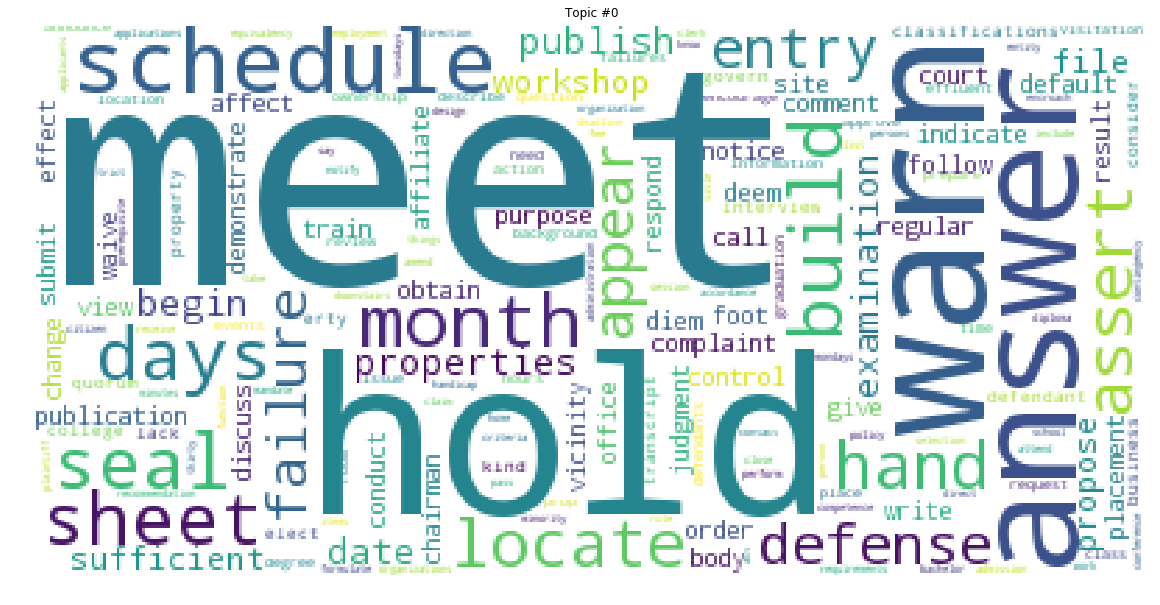

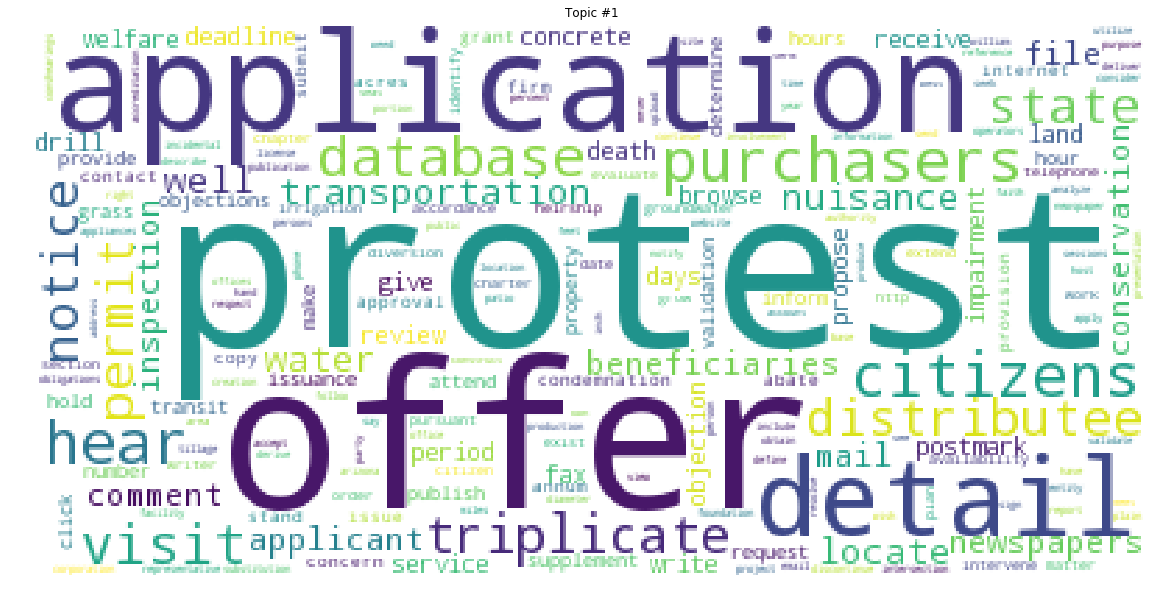

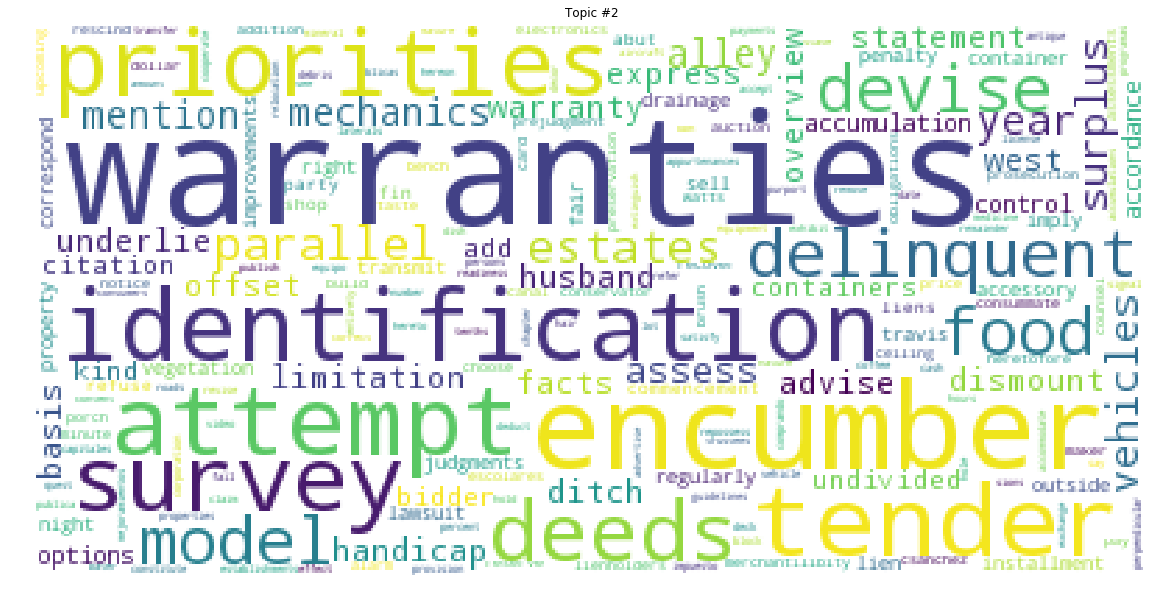

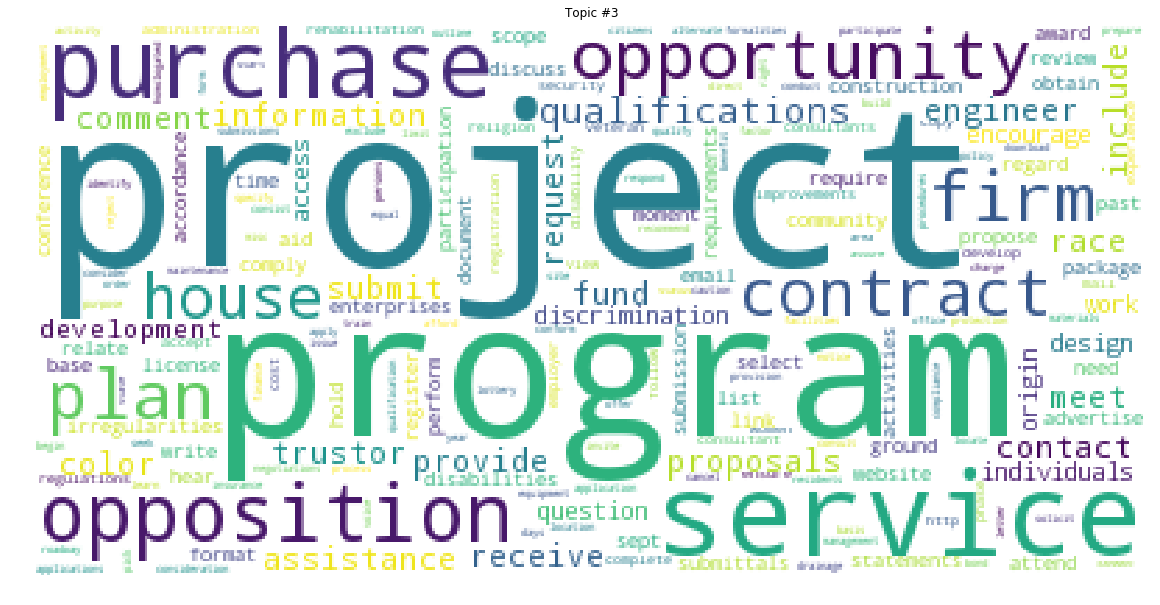

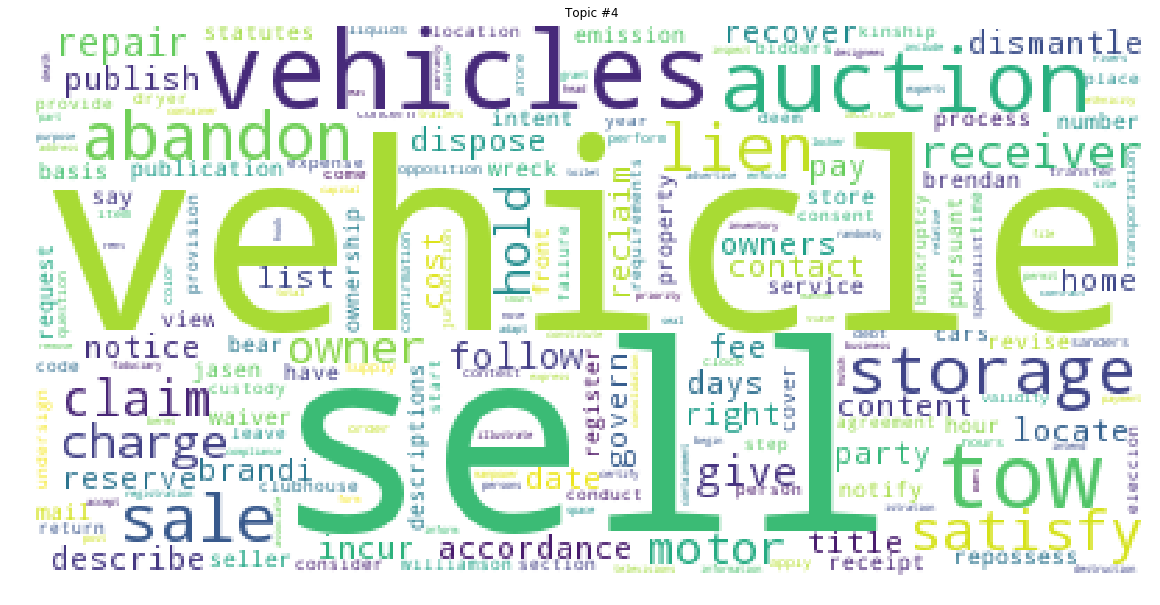

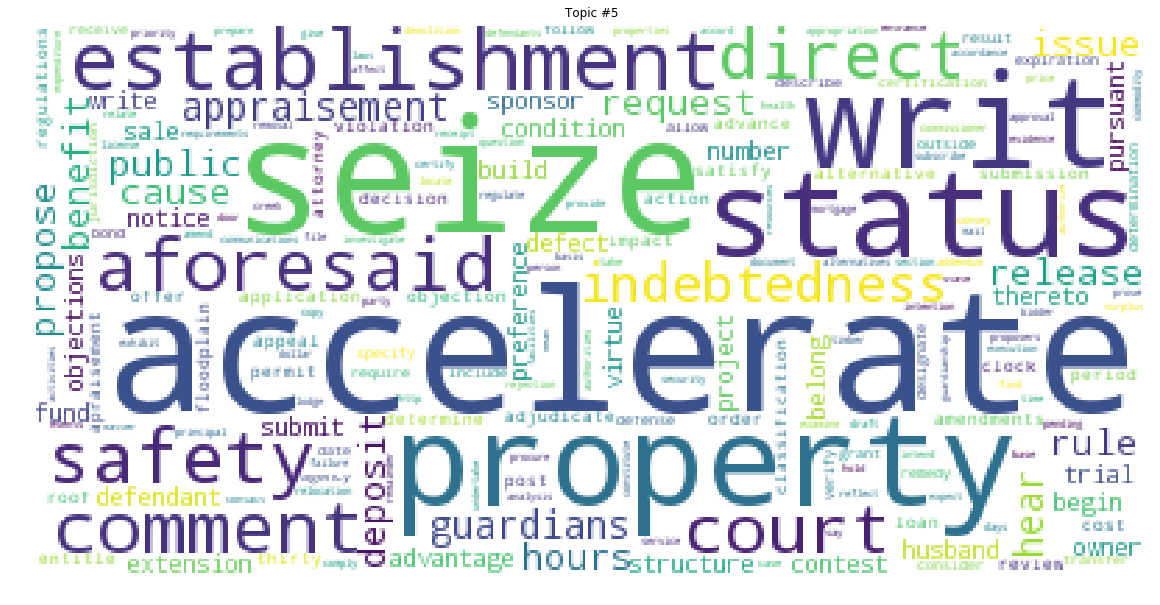

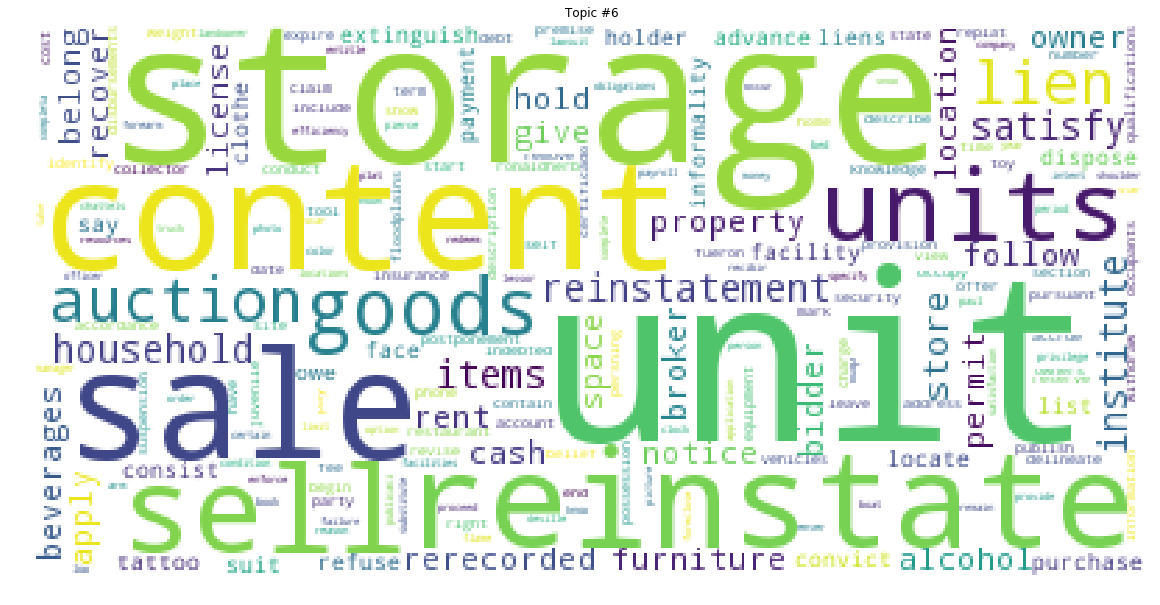

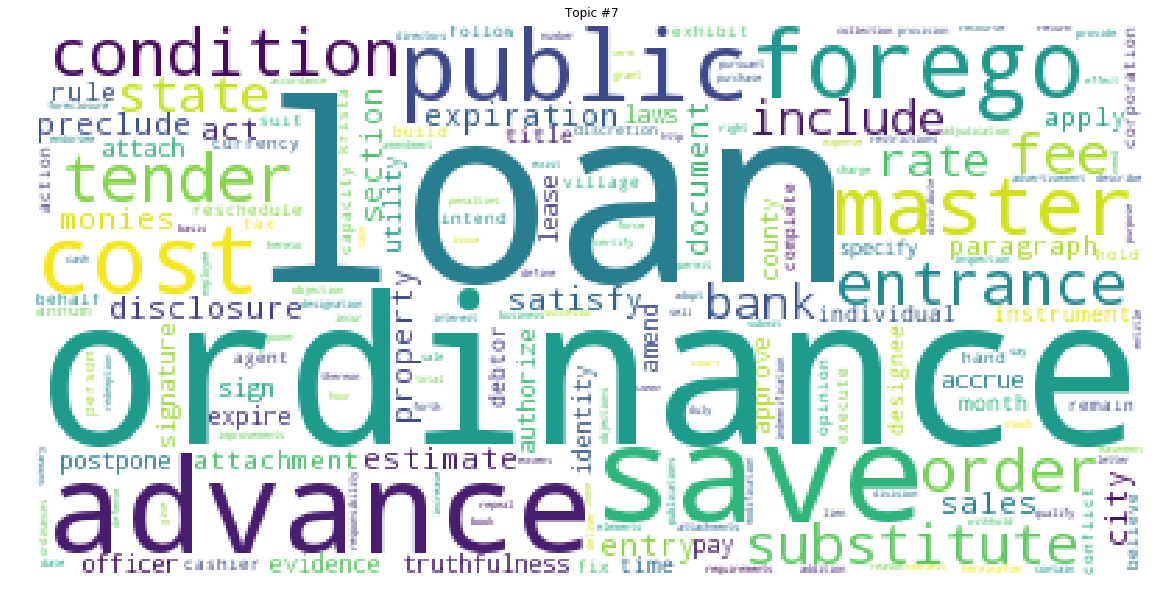

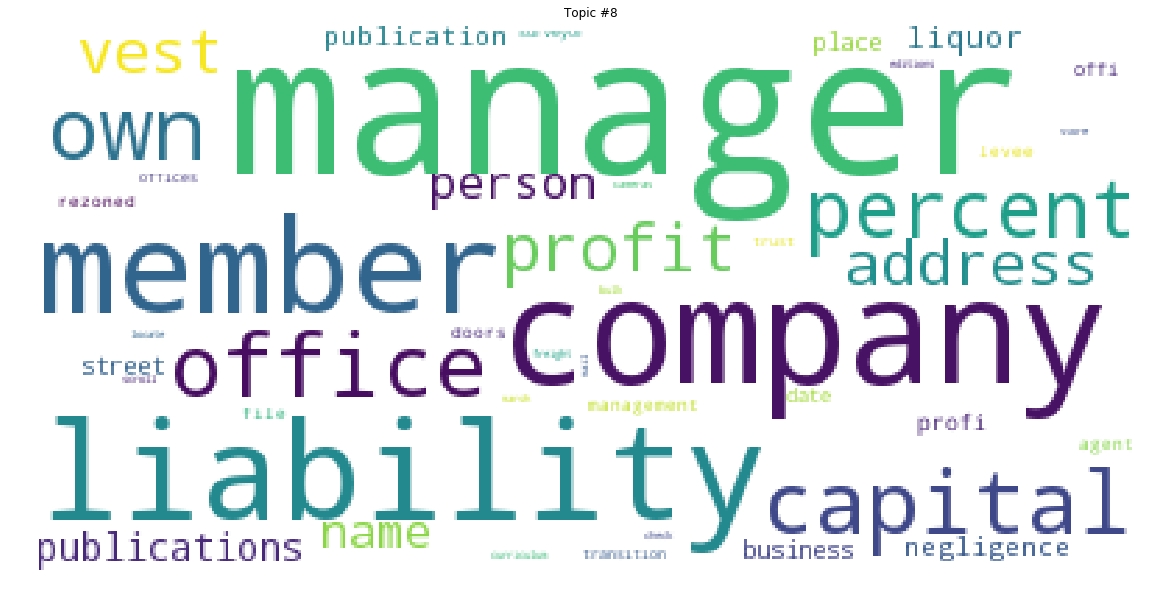

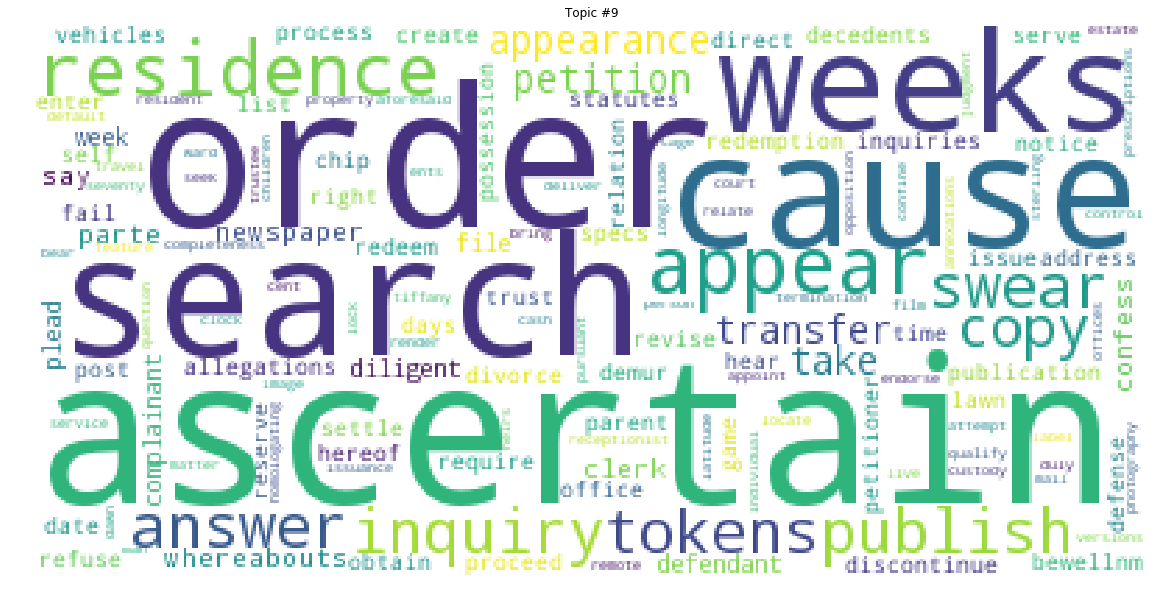

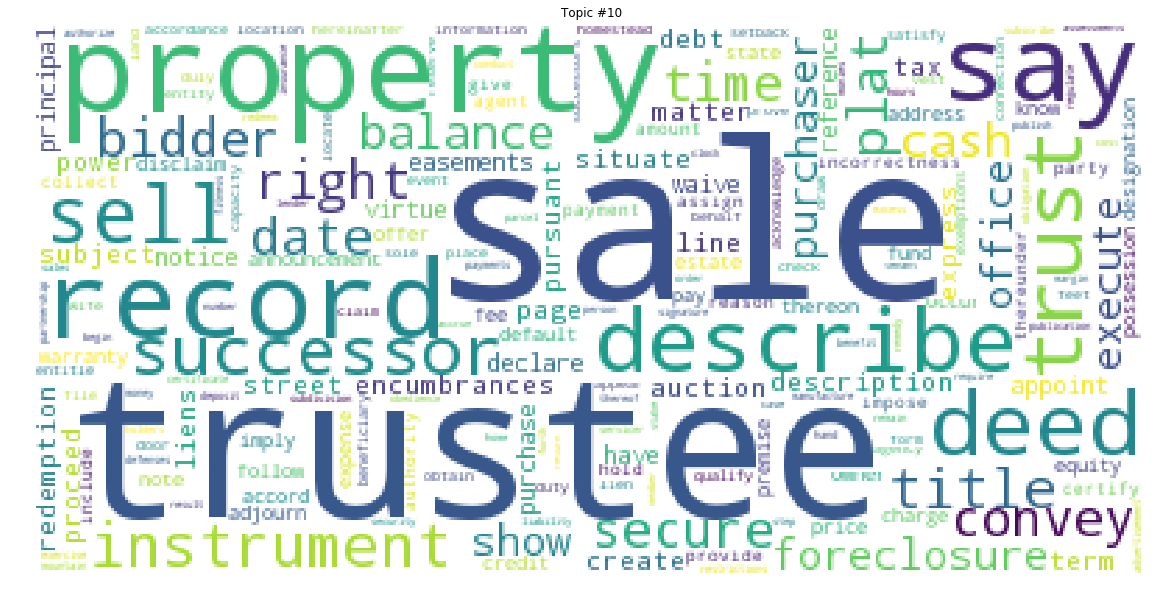

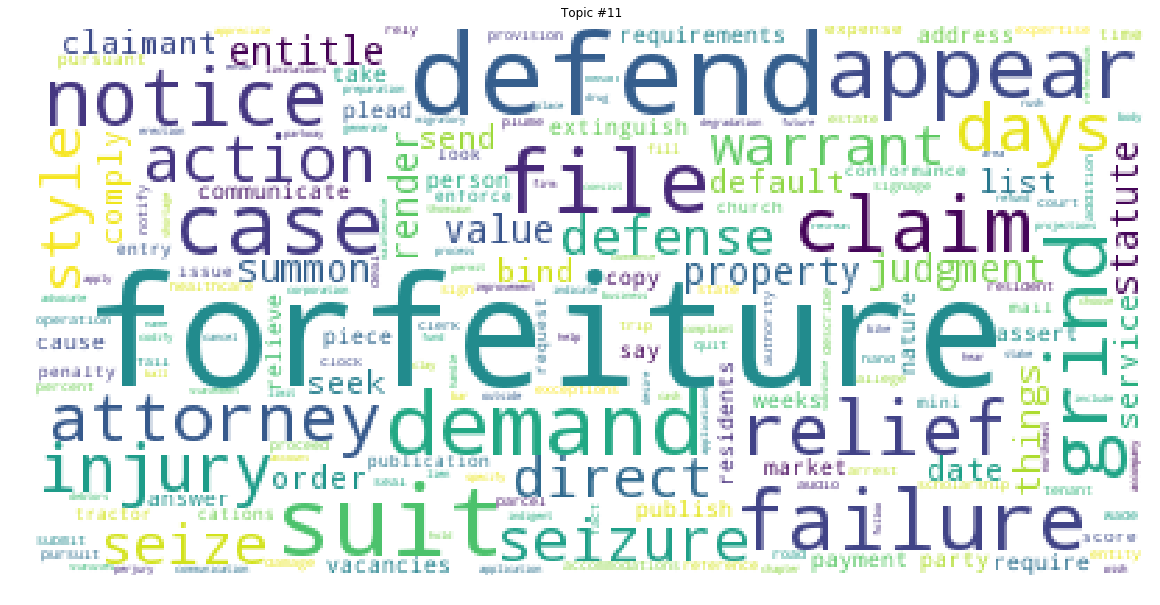

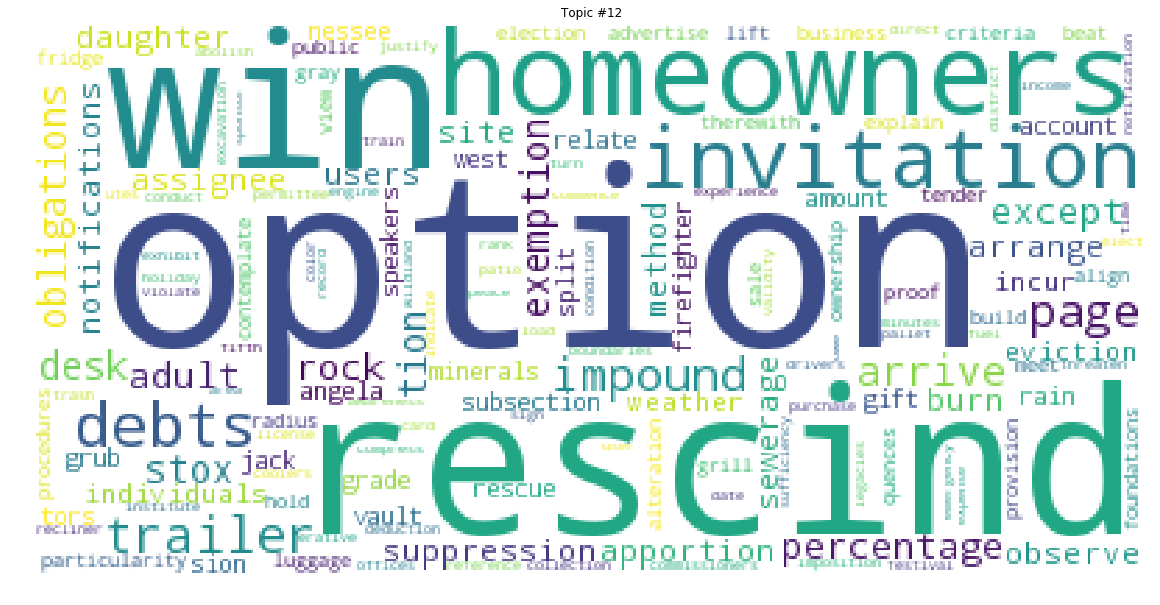

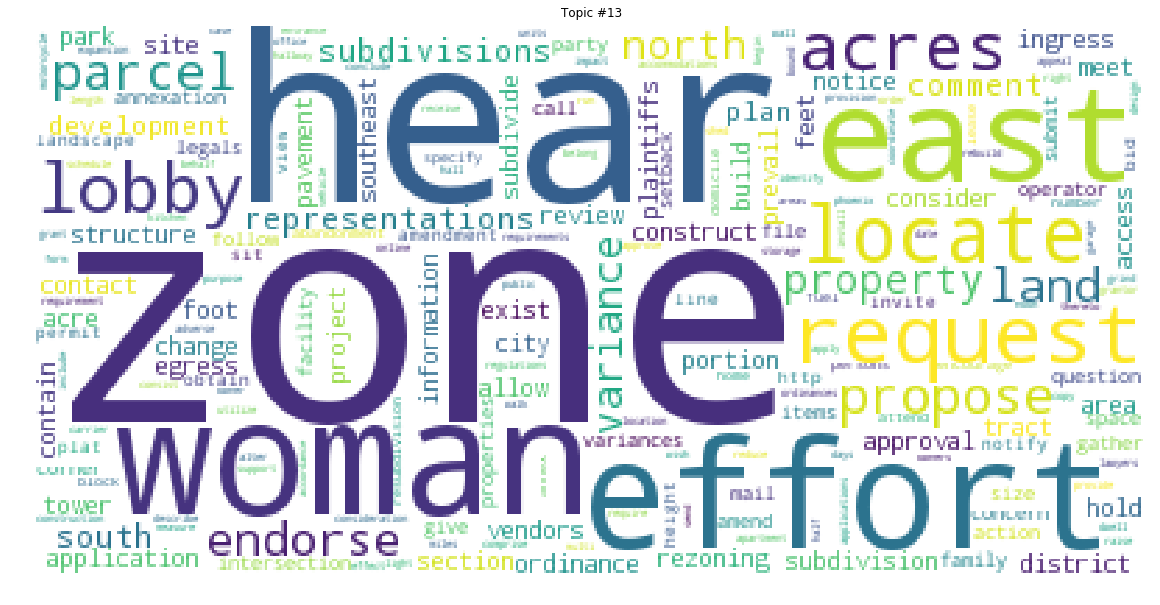

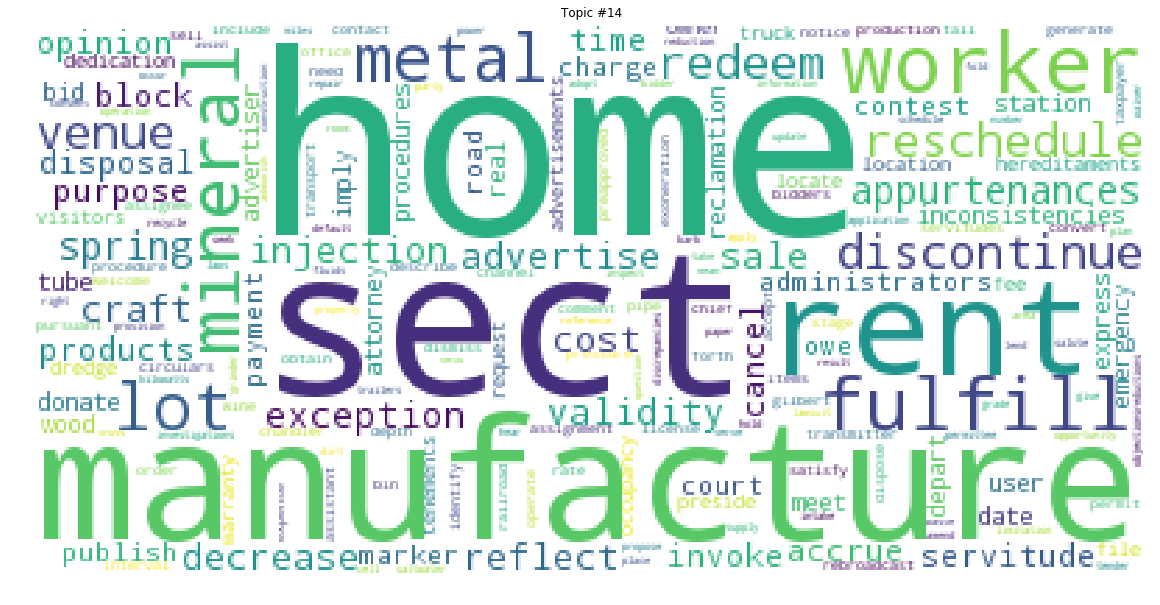

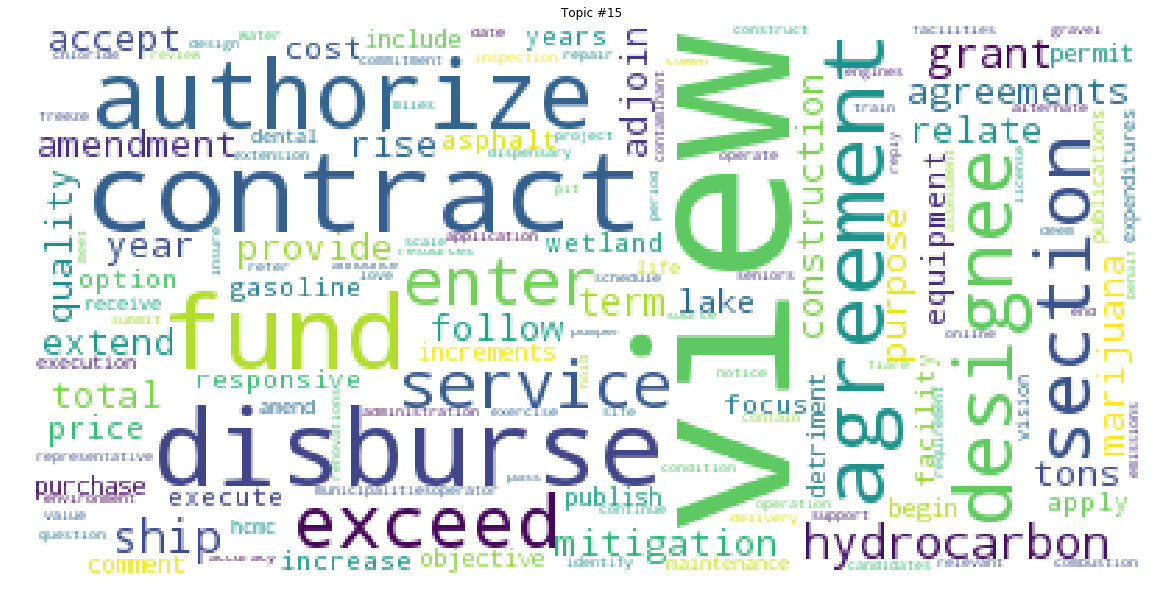

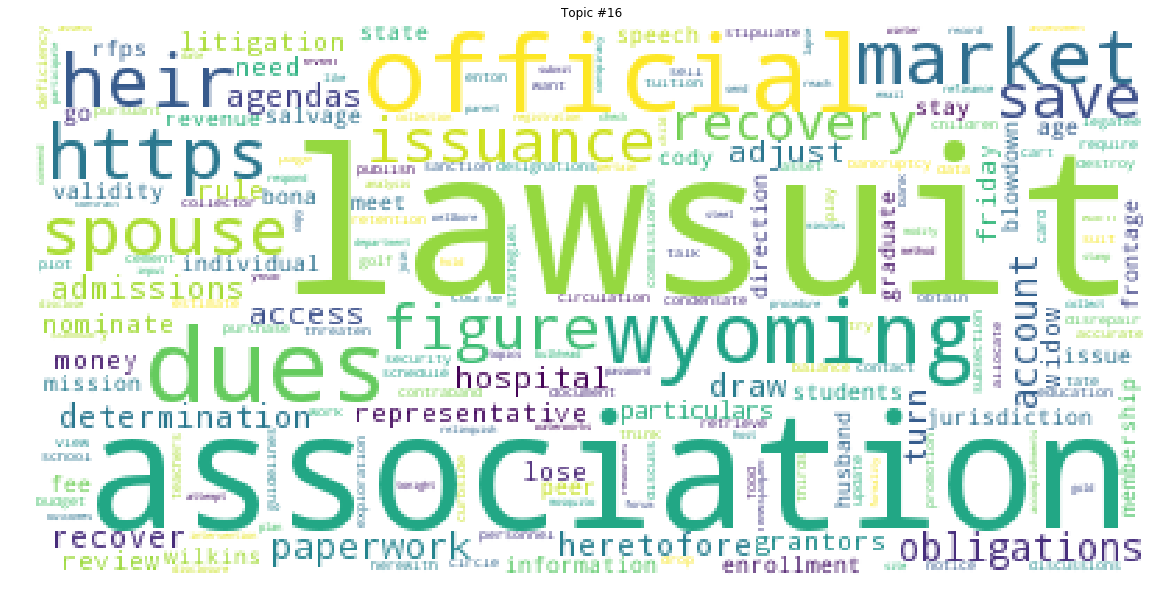

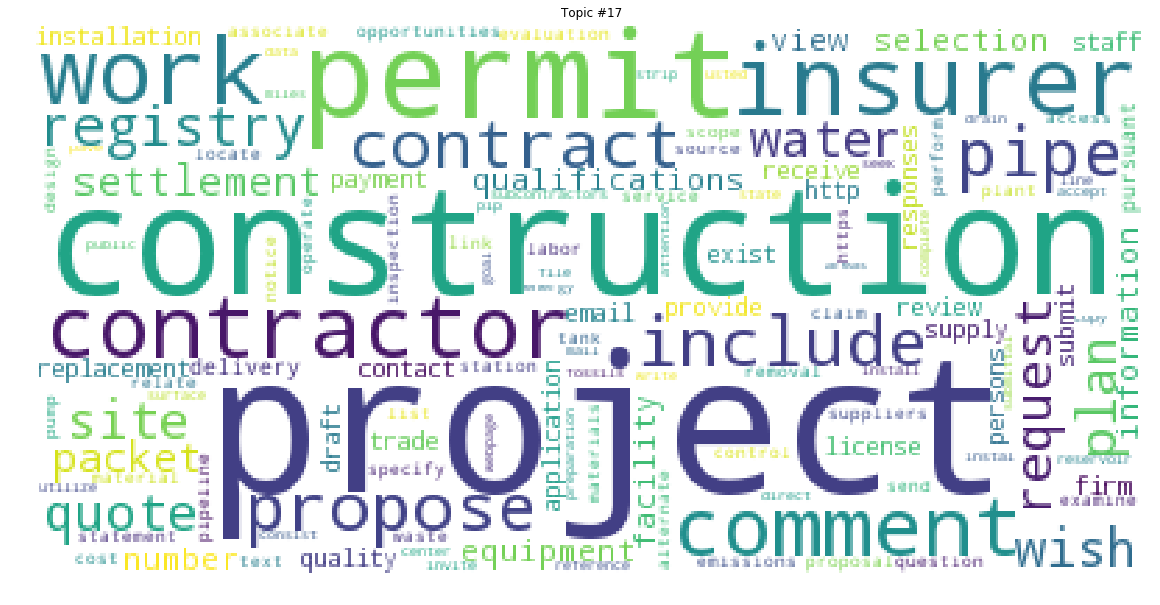

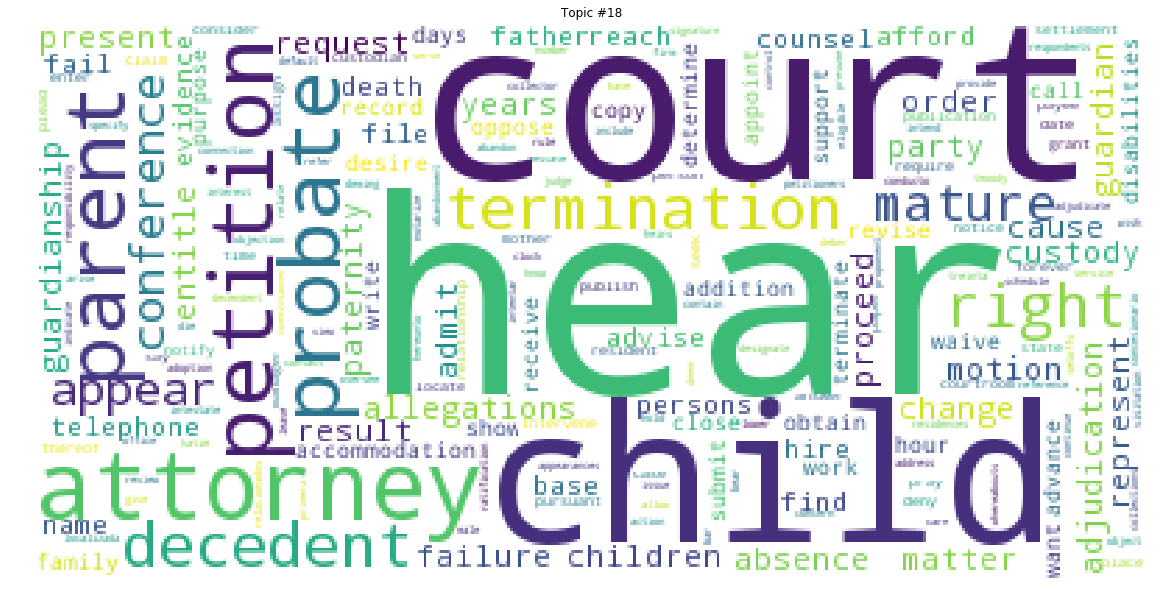

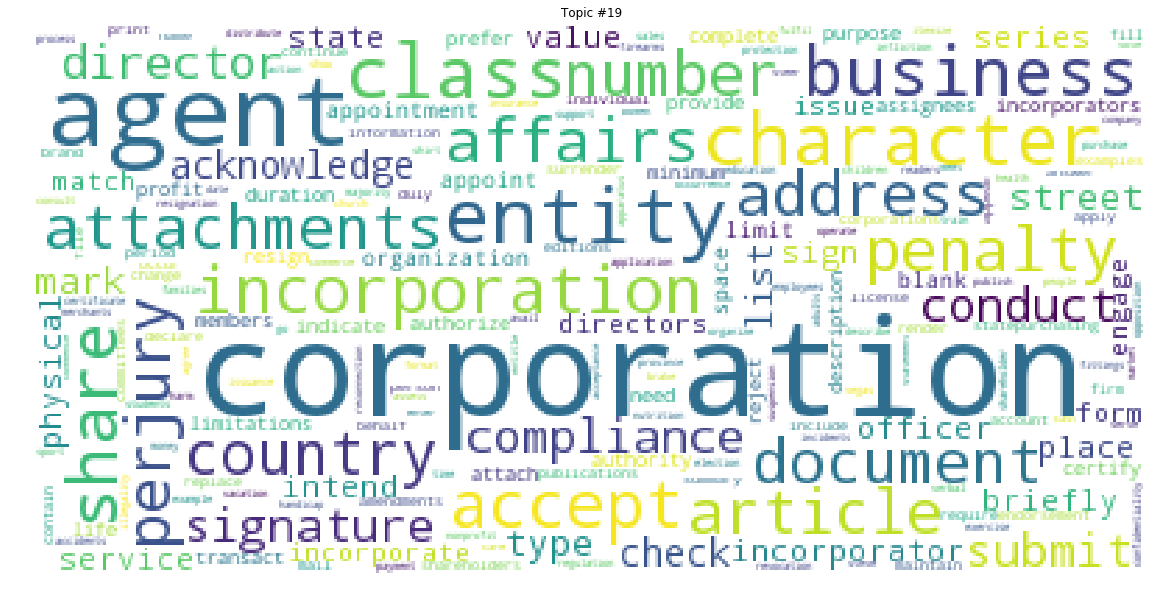

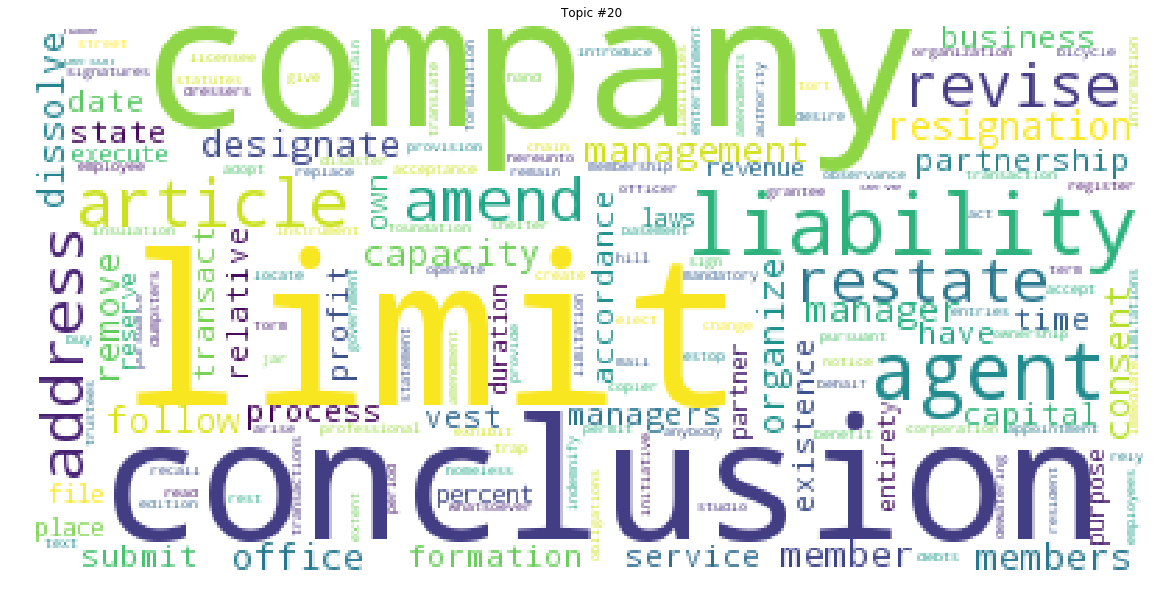

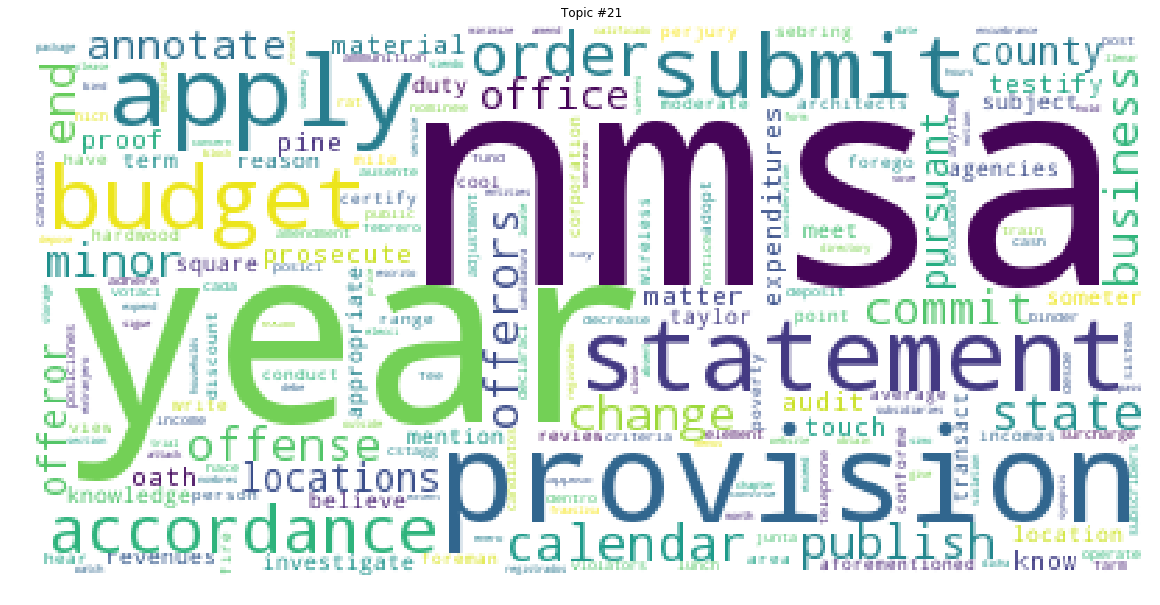

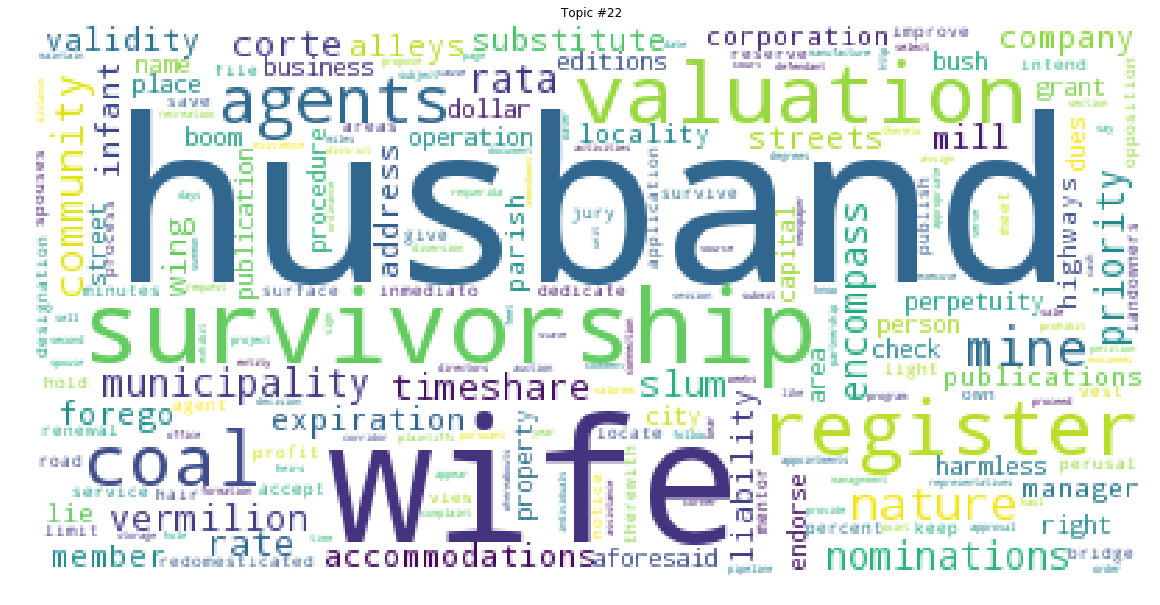

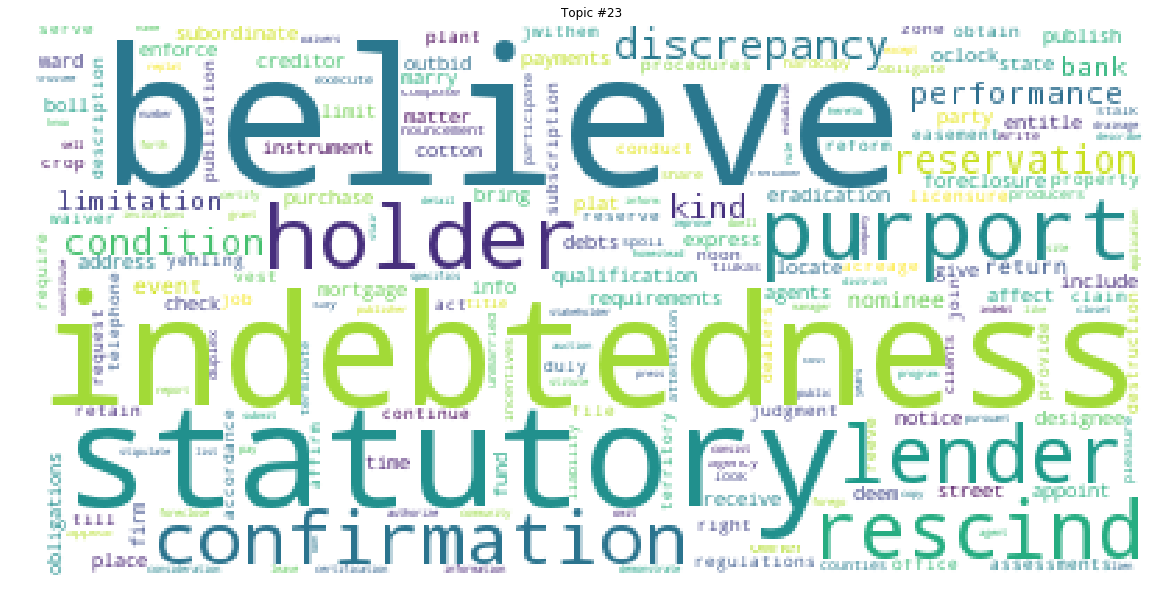

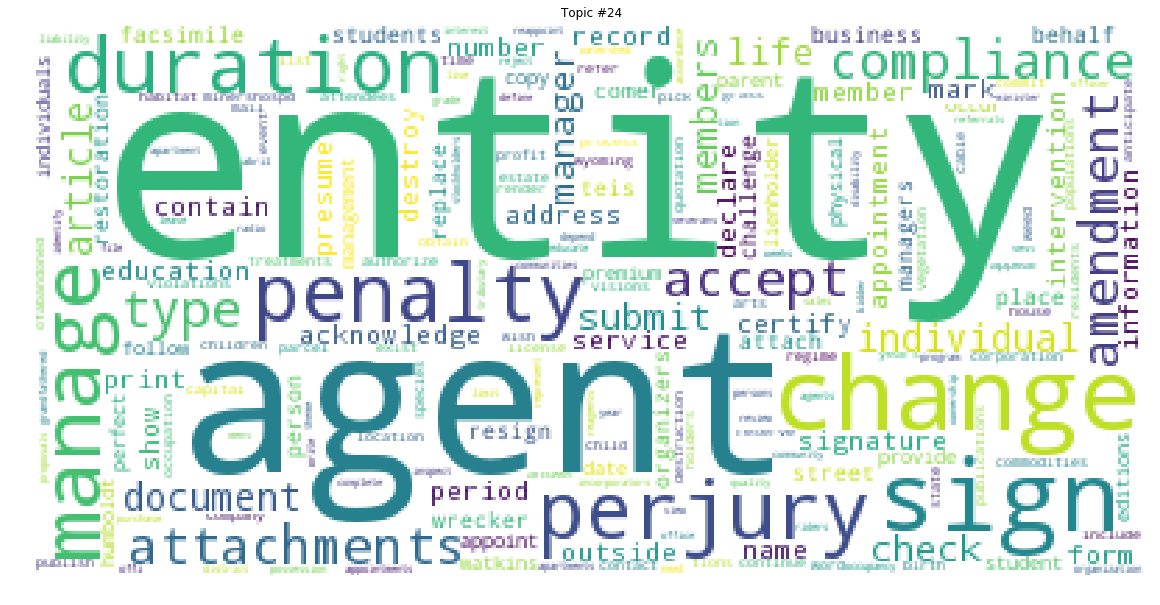

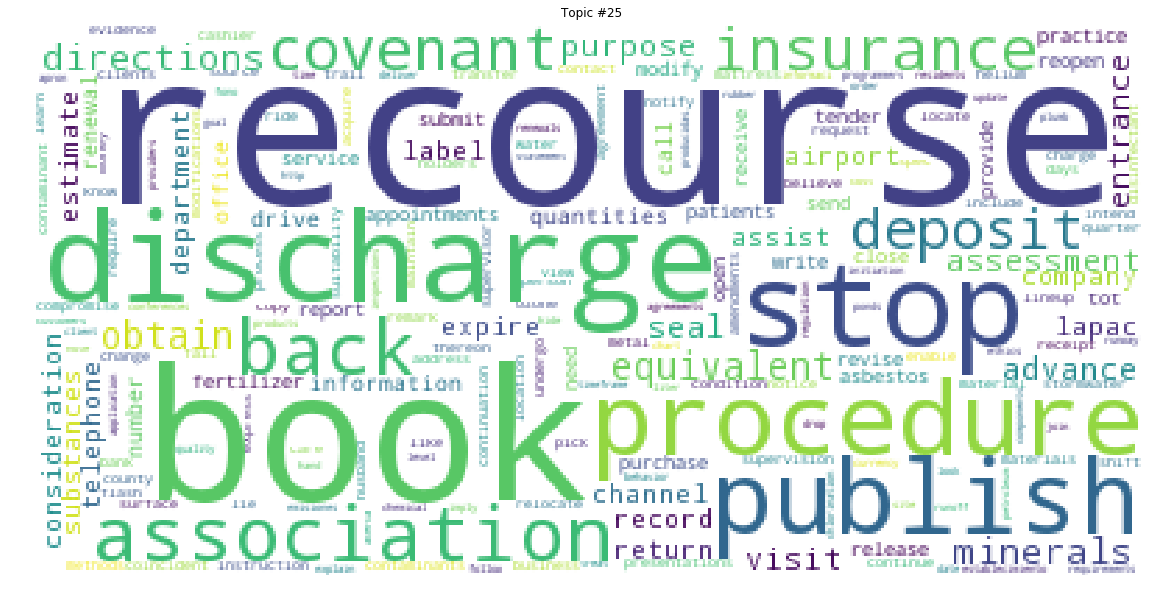

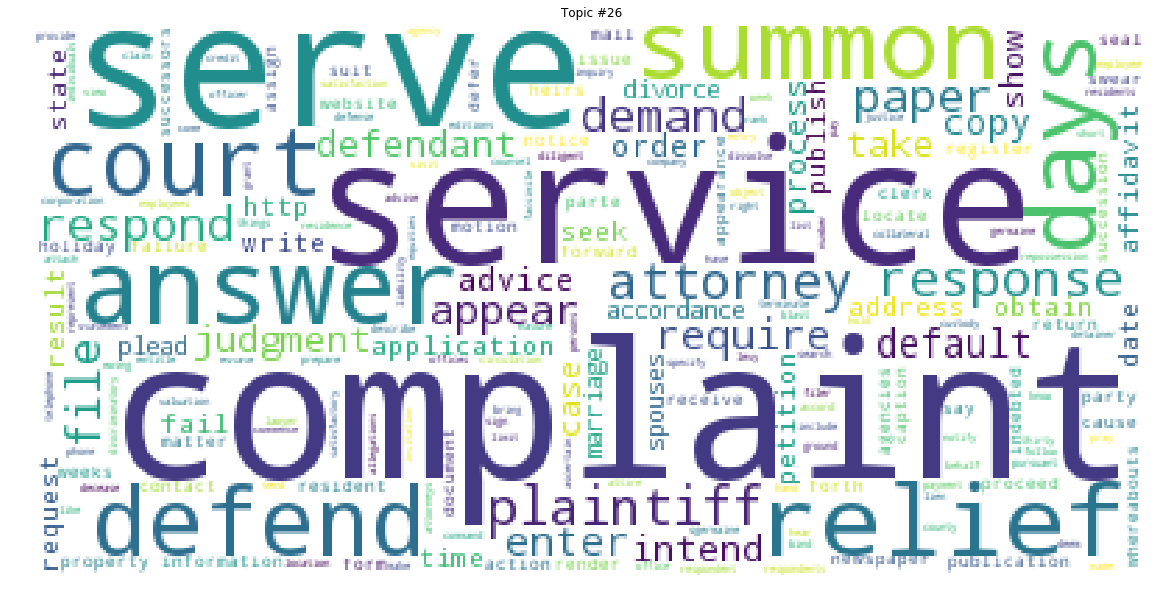

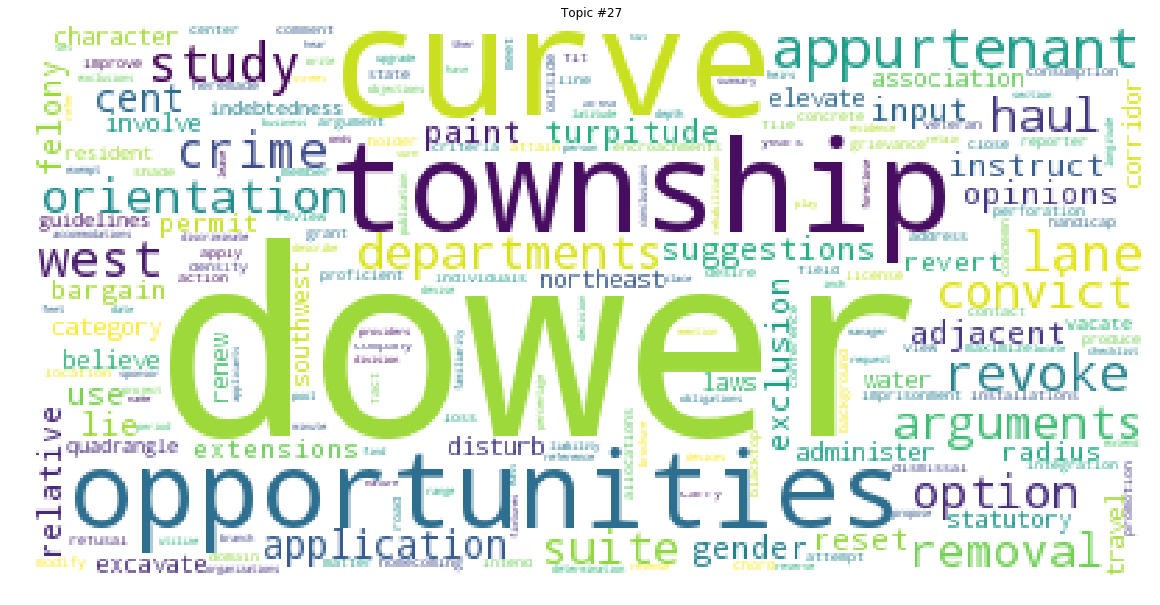

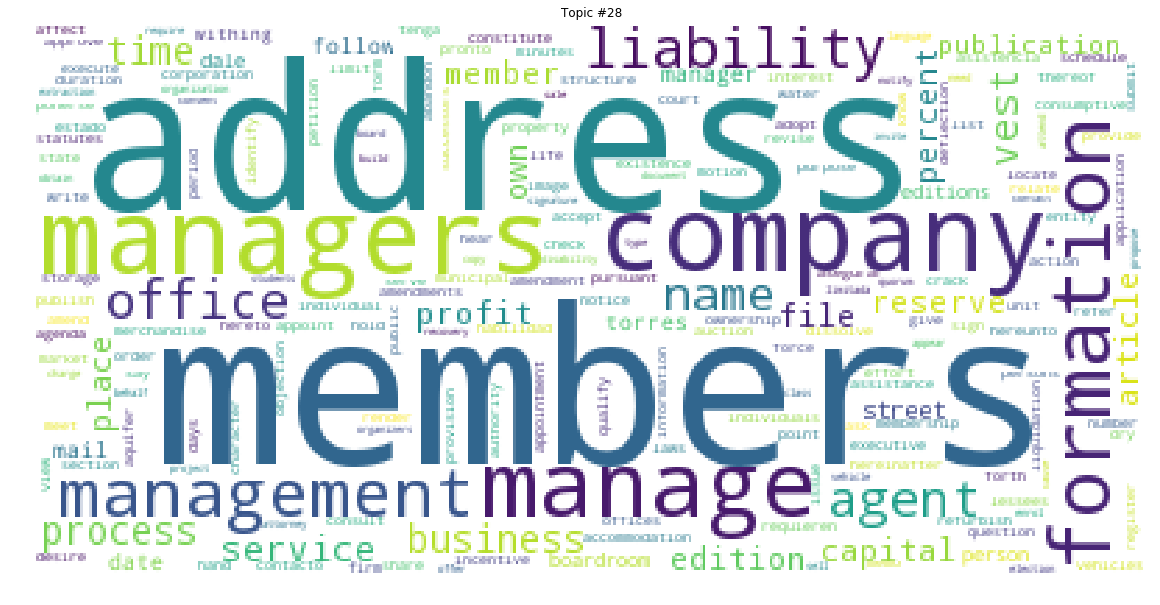

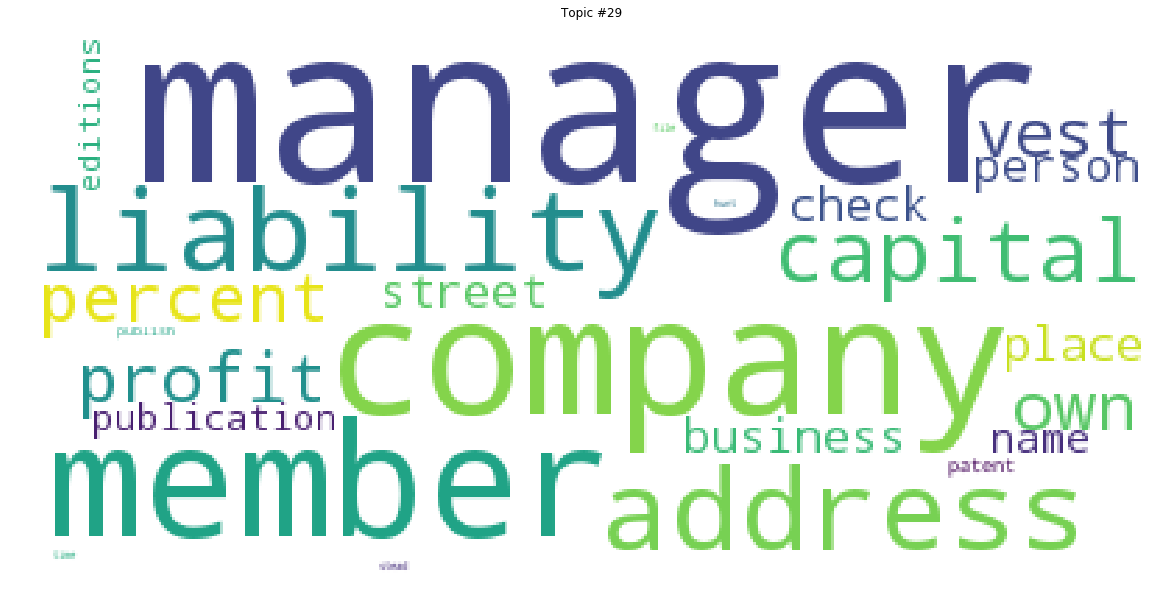

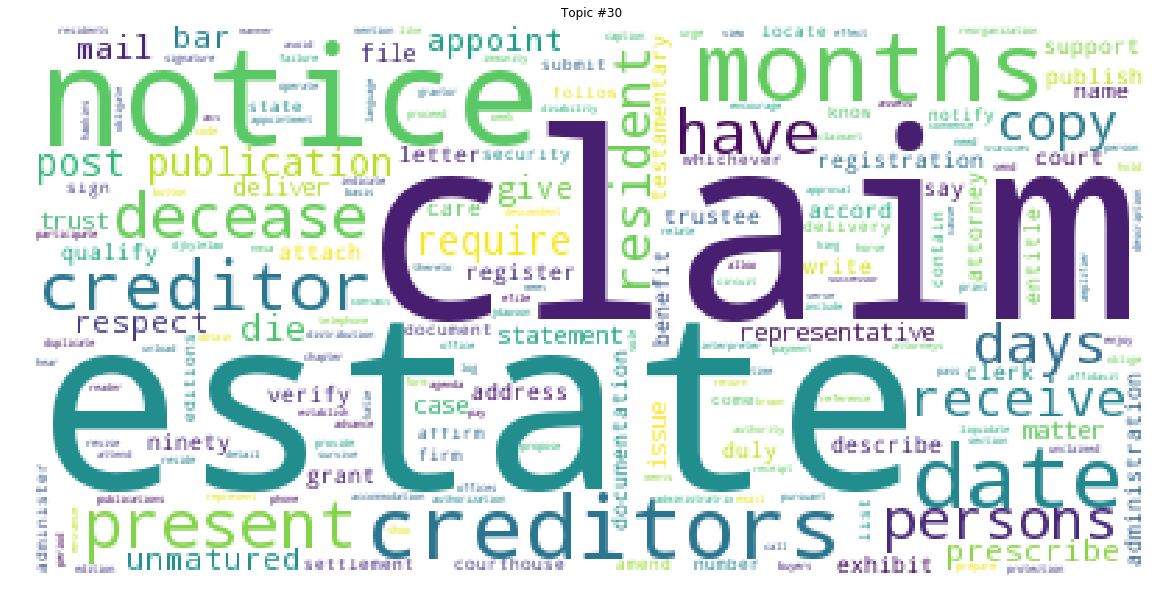

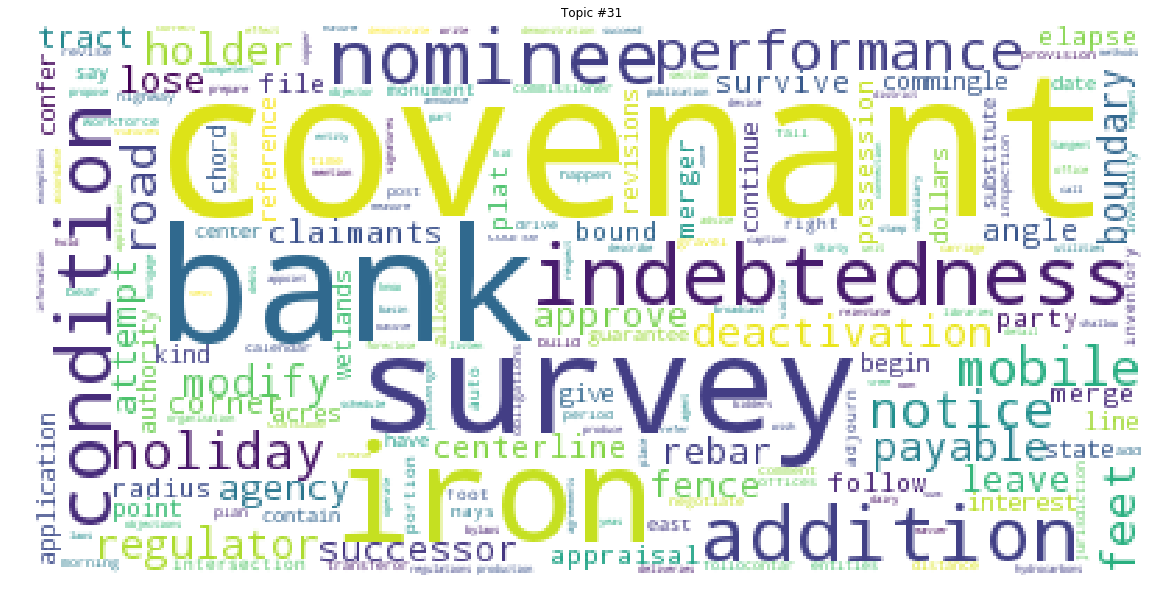

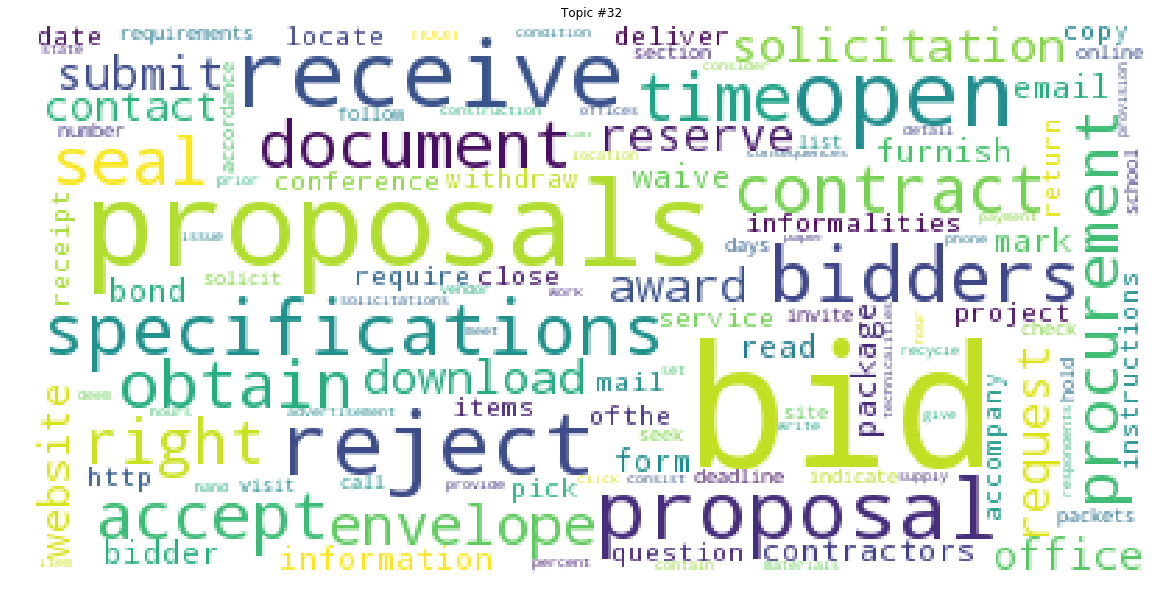

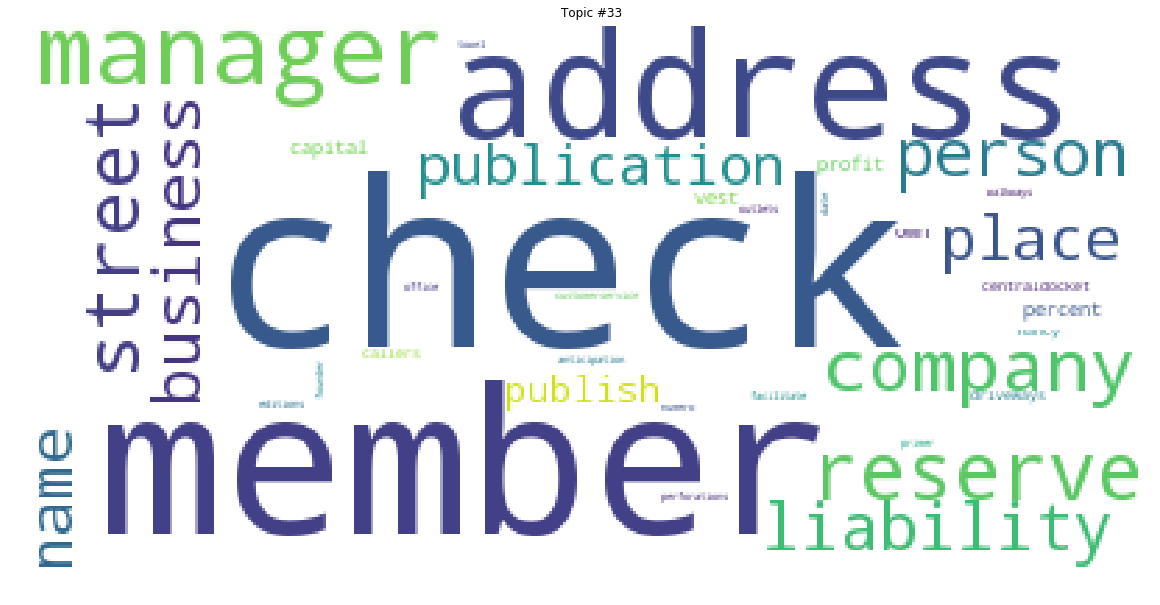

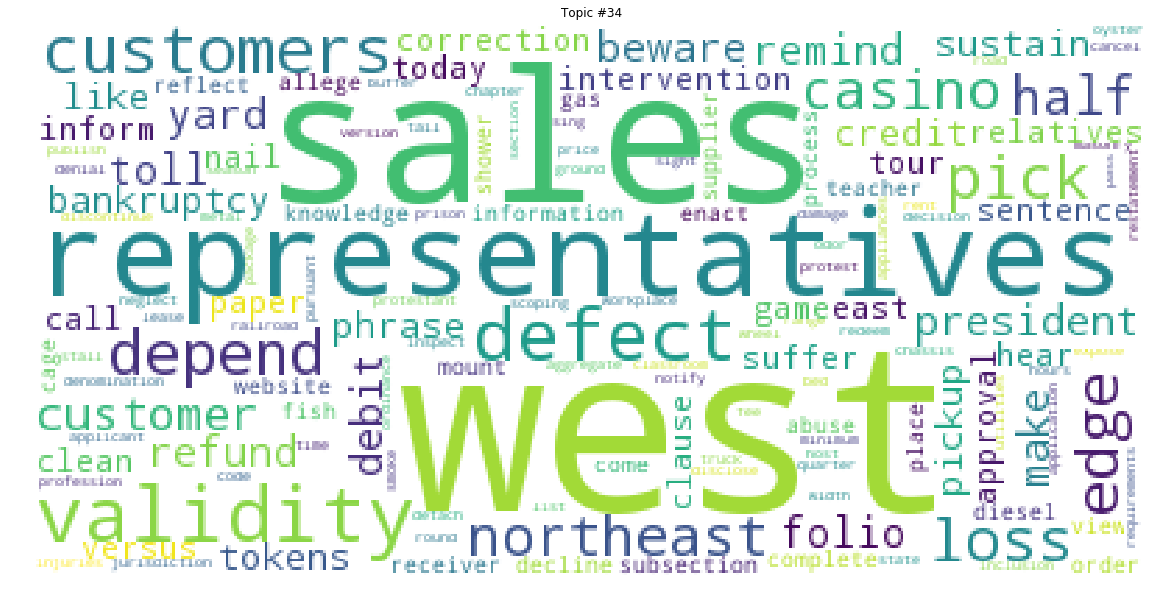

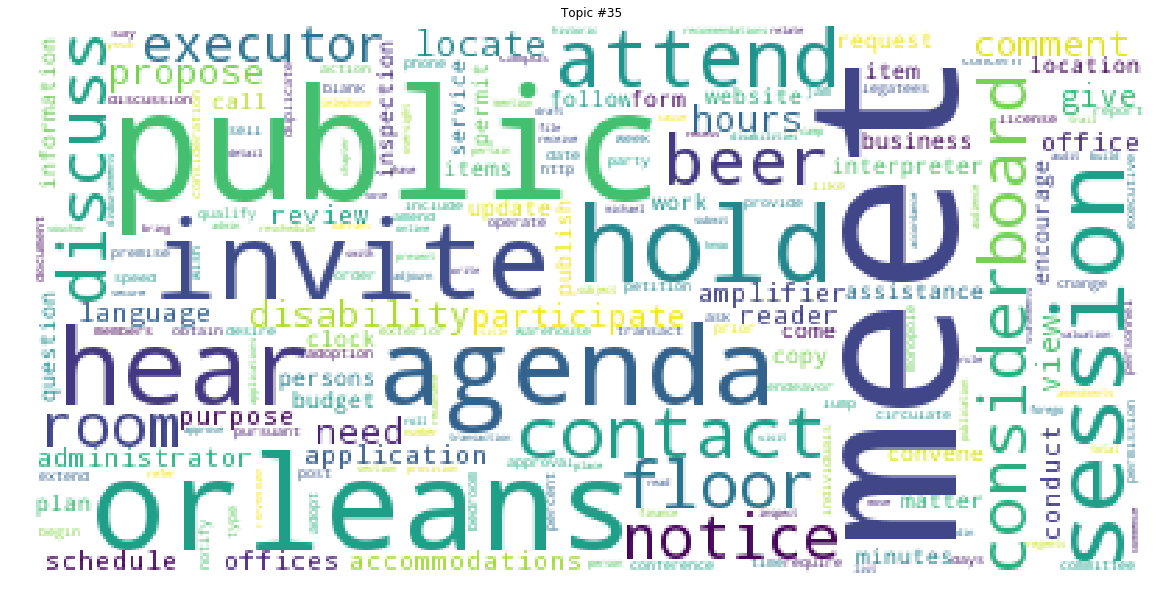

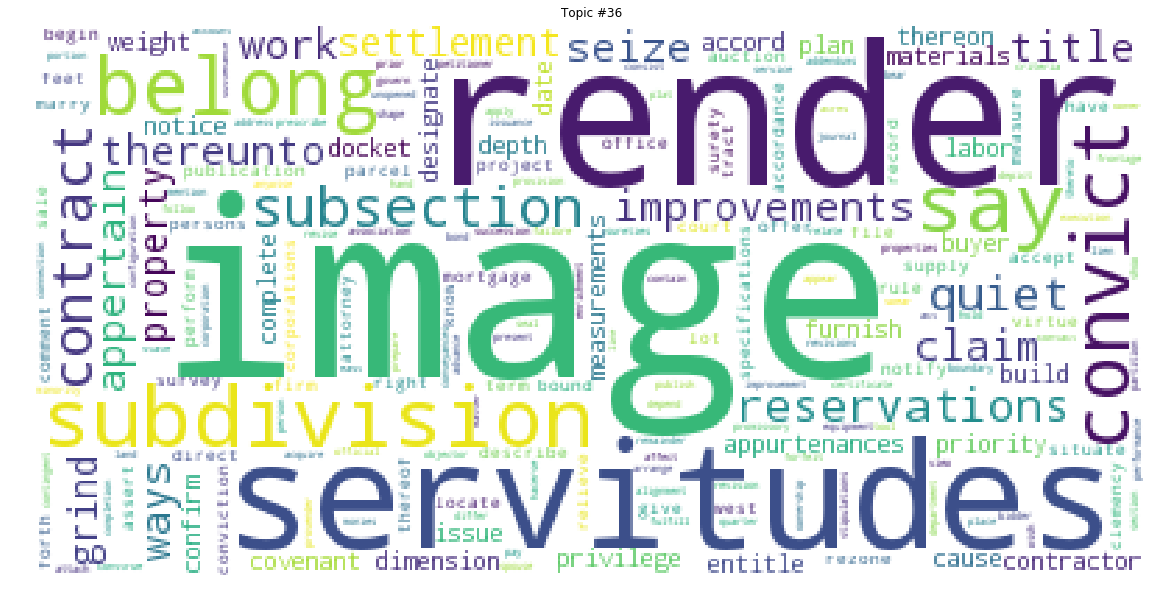

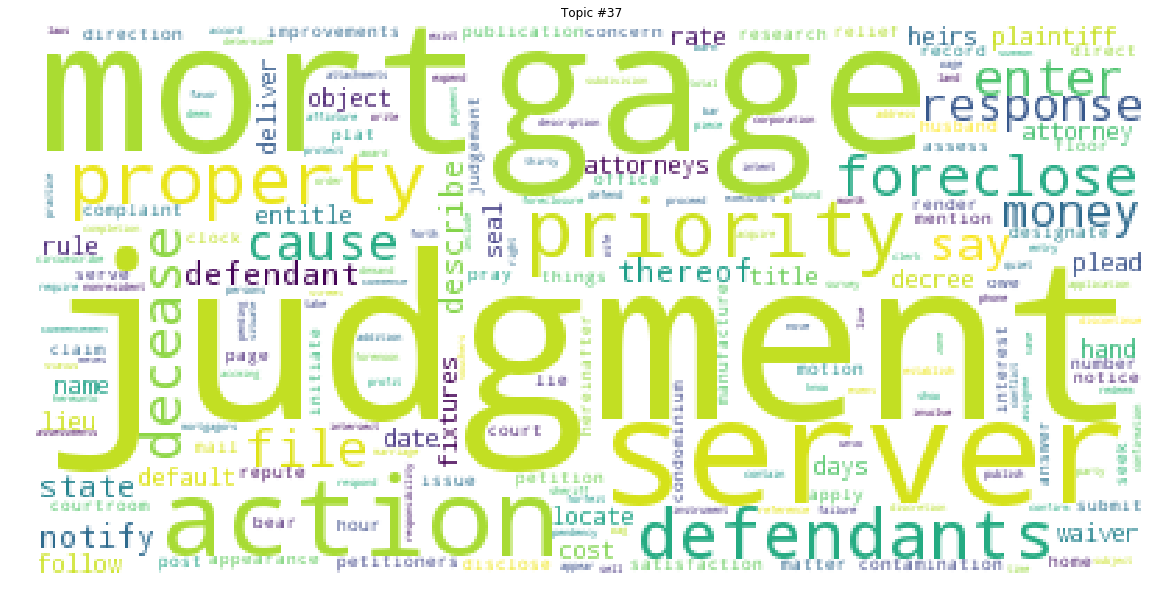

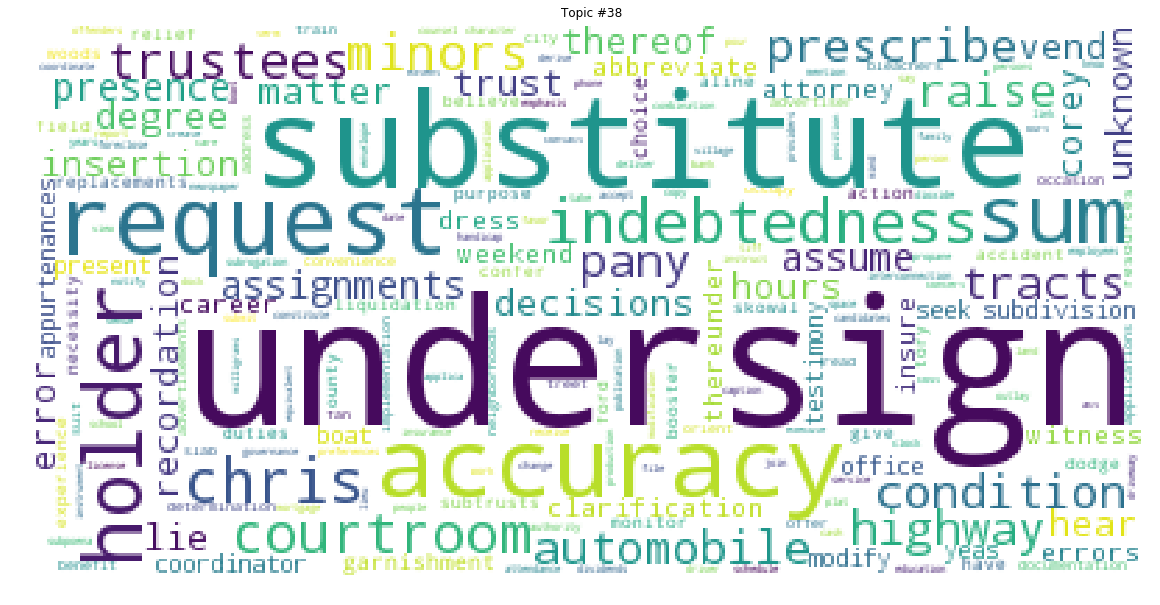

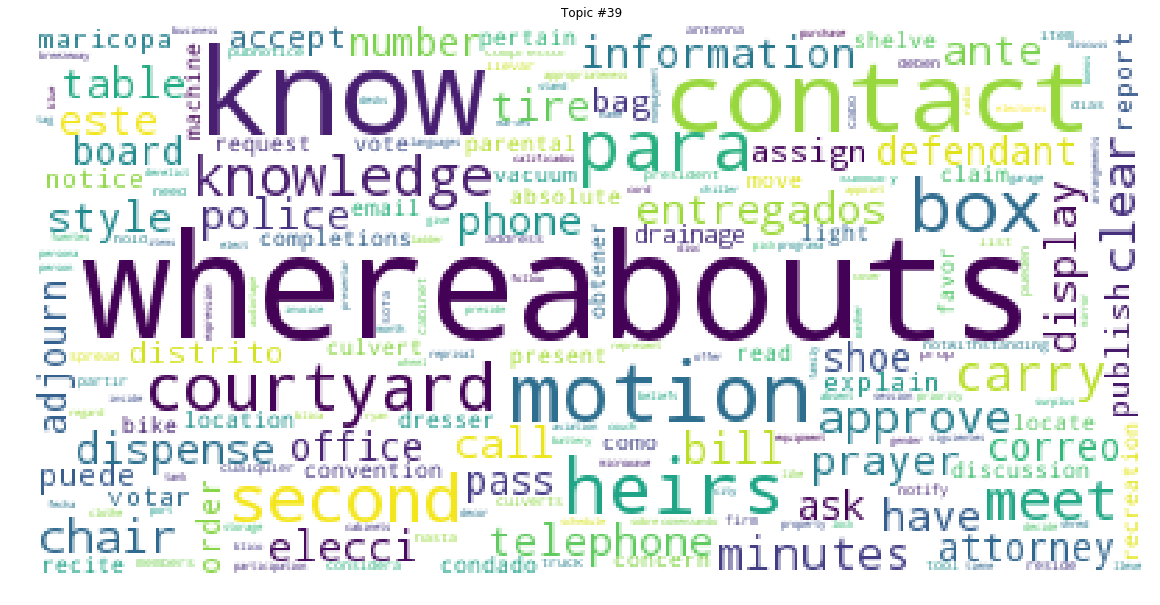

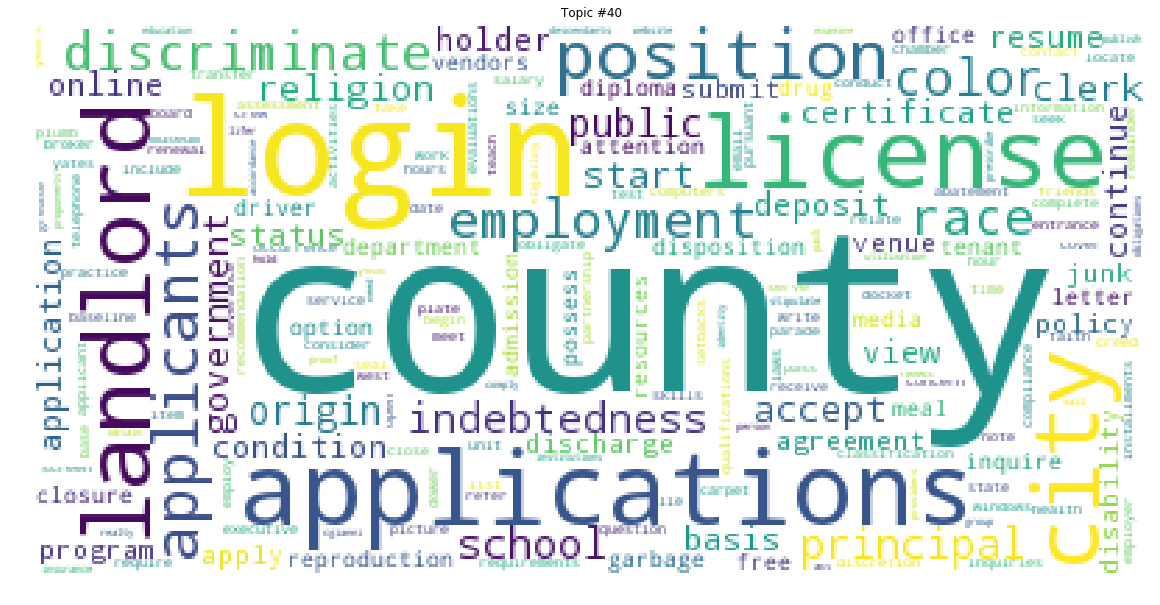

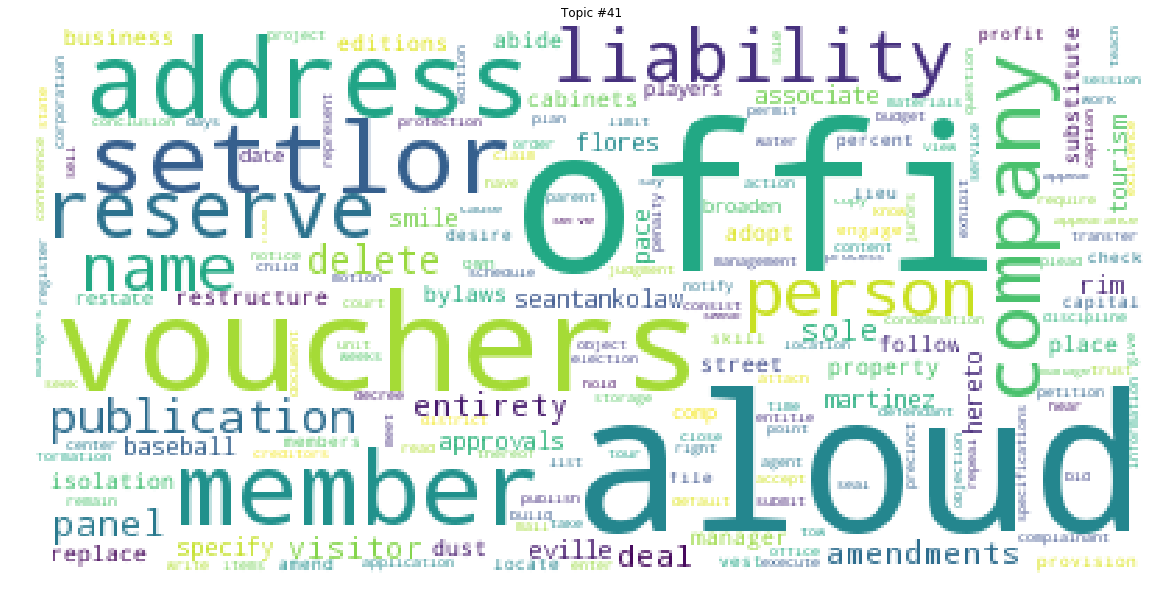

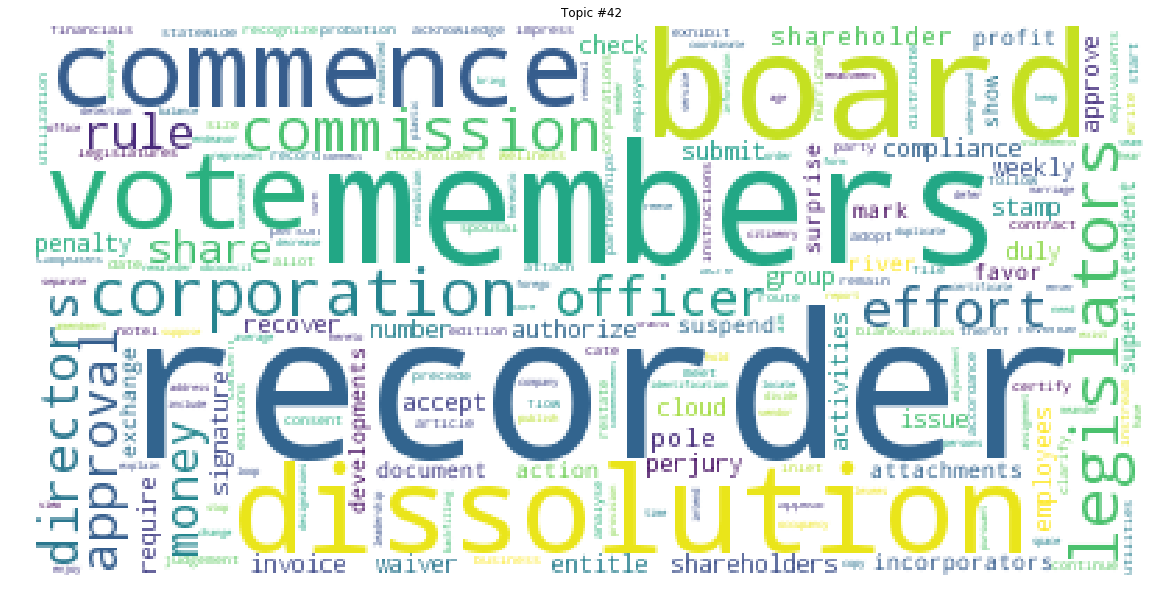

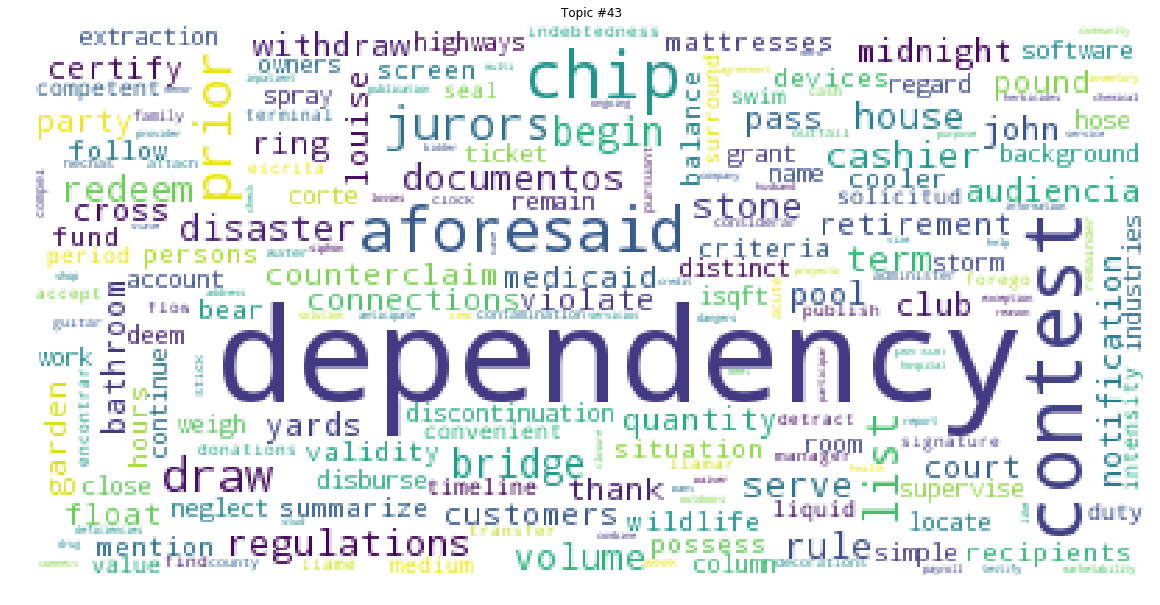

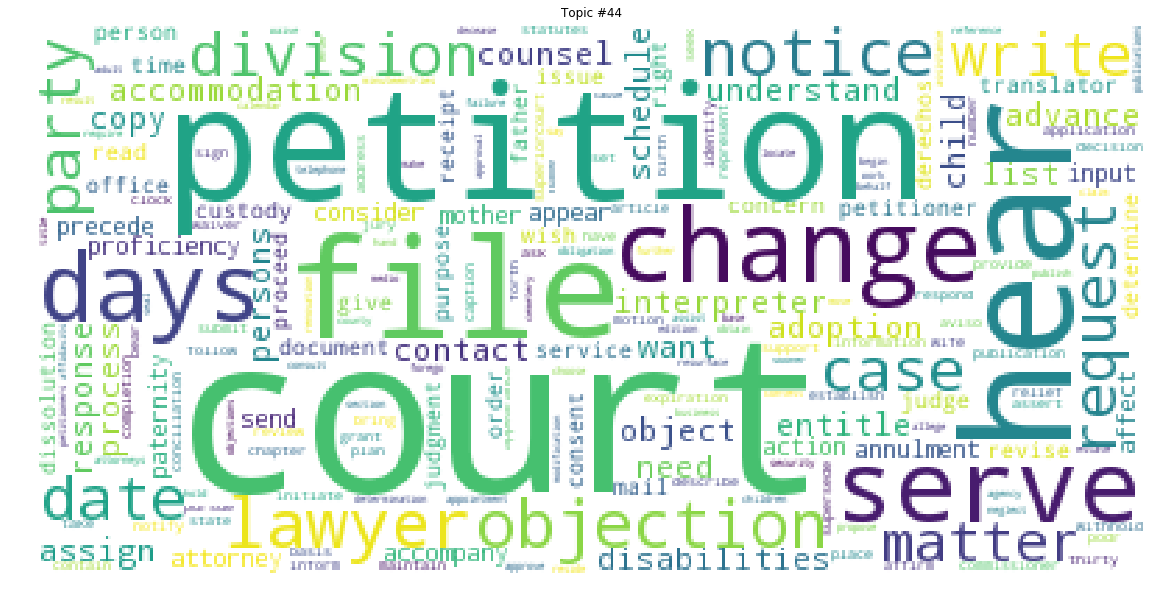

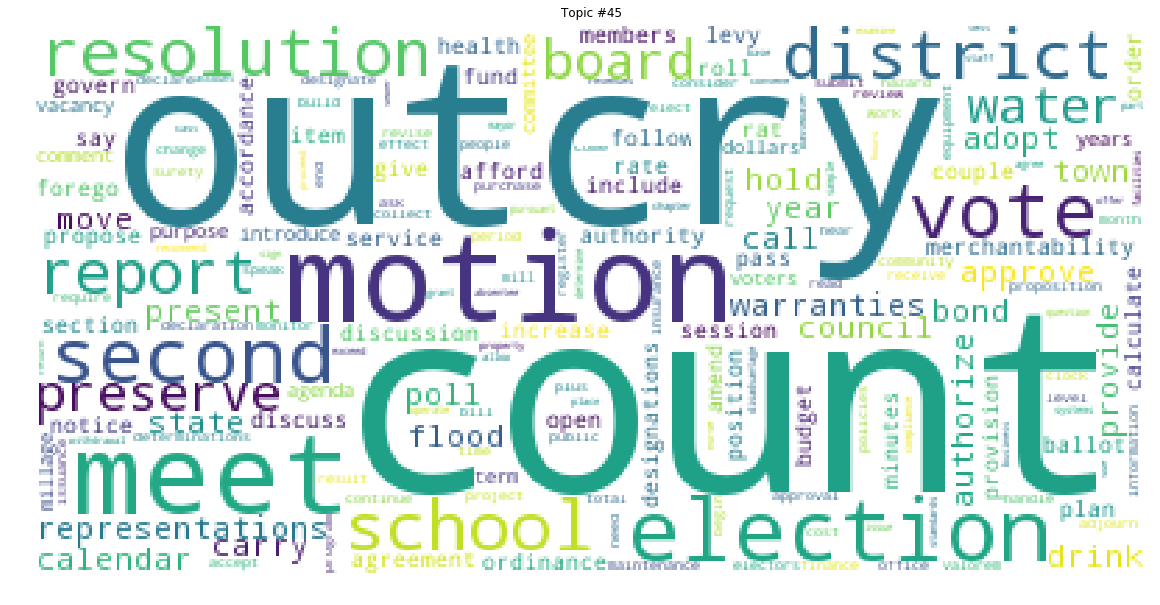

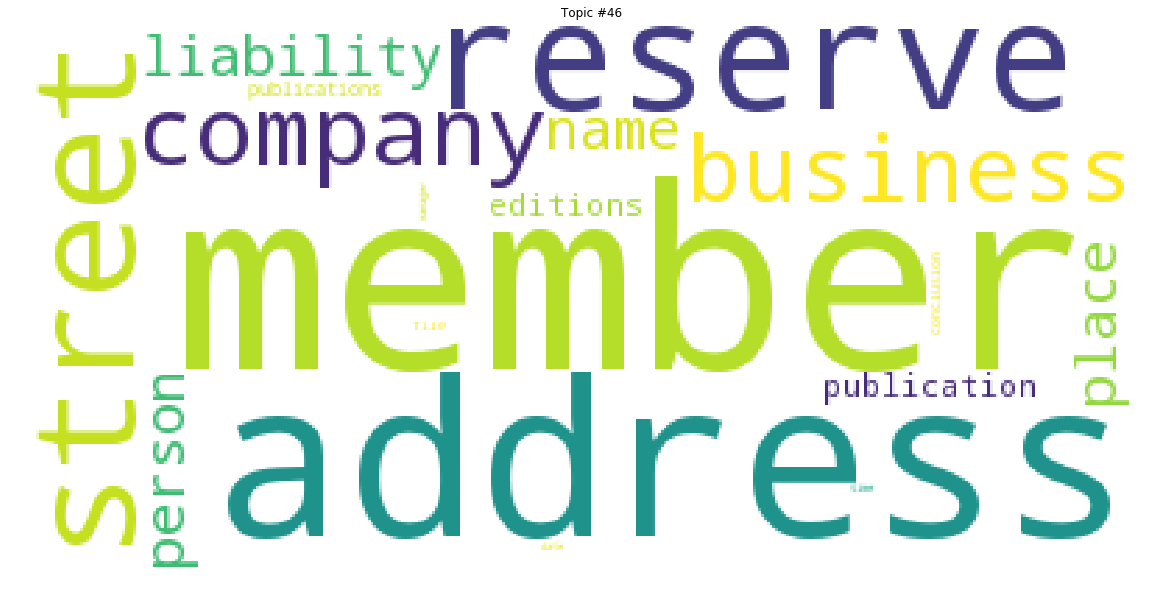

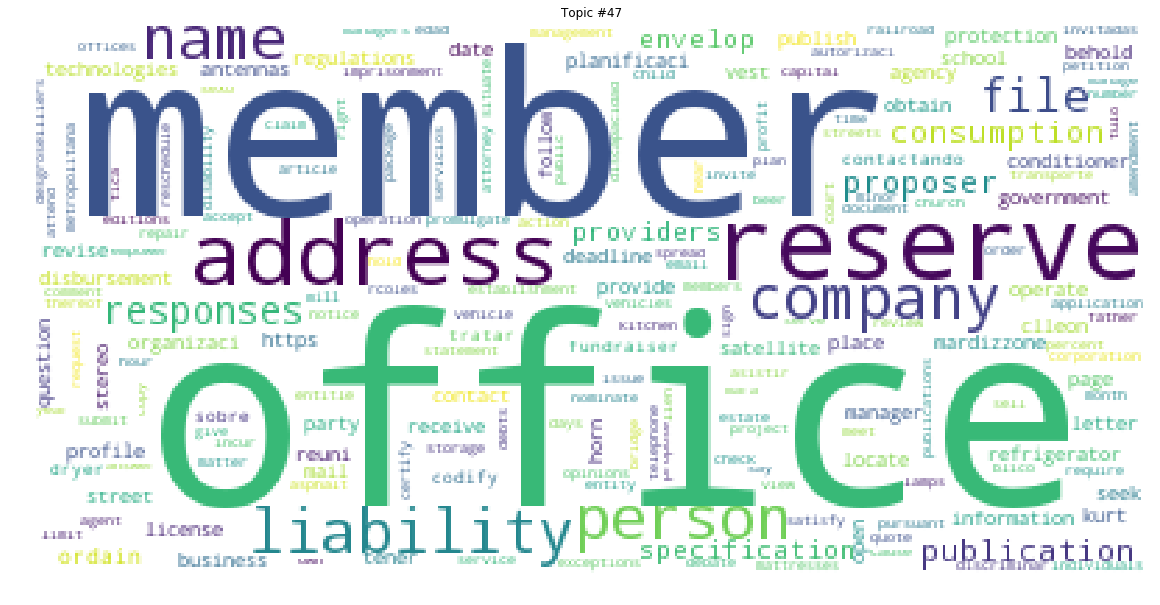

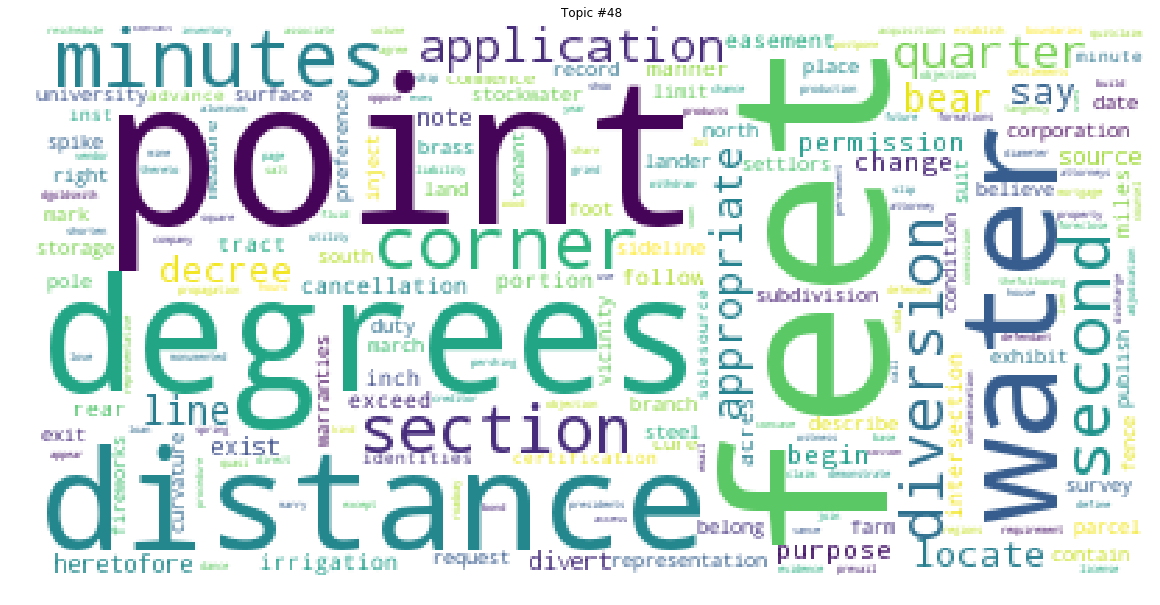

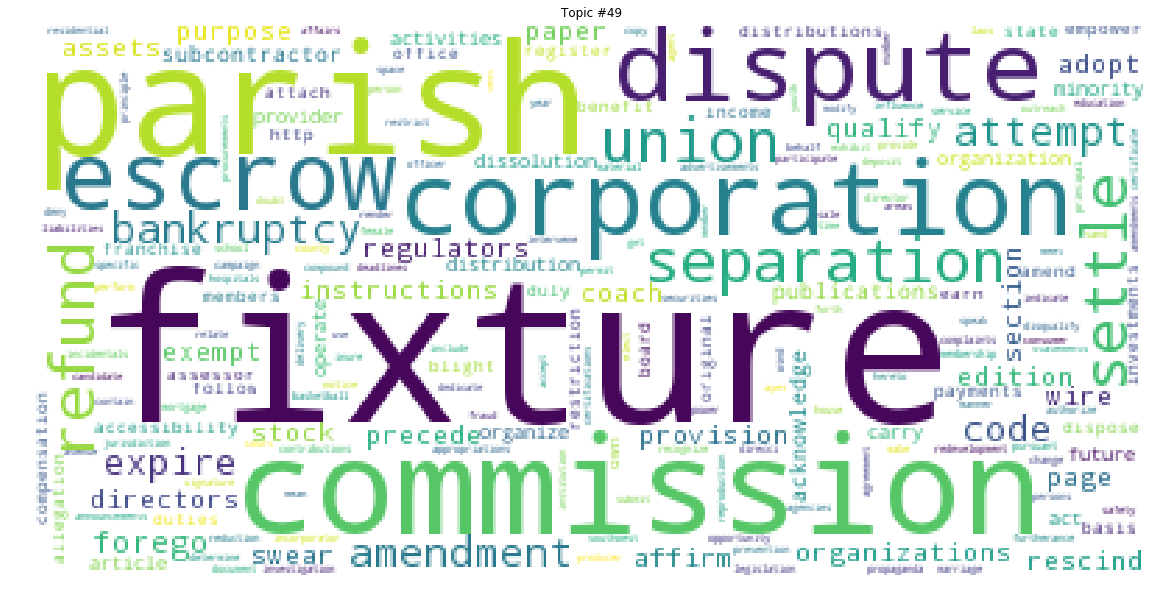

In [0]:
# t = 20
for t in range(50):
  plt.figure(figsize=(20,20))
  plt.imshow(WordCloud(background_color='white').fit_words(dict(lda_model_tfidf.show_topic(t, 1000))))
  plt.axis("off")
  plt.title("Topic #" + str(t))
  plt.show()

In [0]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_tfidf.log_perplexity(corpus_tfidf))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.664629866766739


In [0]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.6126343645507495


In [0]:
# Convert to list
data = sd.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

In [29]:
def format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0            35.0              0.8367   
1            1            30.0              0.3012   
2            2            39.0              0.3008   
3            3            42.0              0.3947   
4            4            40.0              0.3928   
5            5            32.0              0.8600   
6            6            28.0              0.8793   
7            7            40.0              0.3928   
8            8            40.0              0.3927   
9            9             0.0              0.0200   

                                            Keywords  \
0  sale, sell, auction, liens, satisfy, bidder, f...   
1  state, order, file, build, protest, remedy, st...   
2  contract, authorize, dissolution, vote, agreem...   
3  project, plan, propose, comment, construction,...   
4  receive, request, proposals, submit, project, ...   
5  office, book, east, south, pursuant, effort, p...   
6  say, election, state, authority, hold, resolut...   
7  receive, request, proposals, submit, project, ...   
8  receive, request, proposals, submit, project, ...   
9  permit, application, notice, supply, water, ap...   

                                                Text  
0  Notice of Auction On Friday, March 17, 2017 at...  
1  Public Notice On October 28, 2015, the PA Stat...  
2  Click to view PDF. REPAYMENT CONTRACT FOR SAFE...  
3  NOTICE OF MEDICAL PRACTICE CLOSURE: Effective ...  
4  Fort Smith Port Authority is requesting sealed...  
5  ANNUAL STATEMENT OF Shelter Mutual Insurance C...  
6  February 24 Legals NOTICE OF SPECIAL ELECTION ...  
7  Fort Smith Port Authority is requesting sealed...  
8  Fort Smith Port Authority is requesting sealed...  
9  SECTION D, PAGE 66THE RECORD REPORTER, FRIDAY,...

In [32]:
sd.head()

state       county        date  \
0  Mississippi  Pearl River  2017/02/24   
1  Mississippi  Pearl River  2017/02/24   
2      Wyoming      Fremont  2017/02/24   
3  Mississippi  Pearl River  2017/02/24   
4     Arkansas    Sebastian  2017/02/24   

                                             content                category  
0  Notice of Auction\nOn Friday, March 17, 2017 a...            ['Auctions']  
1  Public Notice\nOn October 28, 2015, the PA Sta...  ['License Suspension']  
2  Click to view PDF.\n\nREPAYMENT CONTRACT FOR S...                      []  
3  NOTICE OF MEDICAL PRACTICE CLOSURE:\nEffective...                      []  
4  Fort Smith Port Authority is requesting sealed...                      []

In [31]:
df_dominant_topic['Text'].iloc[0]

'Notice of Auction On Friday, March 17, 2017 at 9am, we will be holding an AUCTION on the following abandoned/wrecked vehicle: 1984 Oldsmobile 88 VIN# 1G3BN69Y3FY328464 Road Assist 24, 3066 Hwy 43 S., Picayune, MS 39466 Publish: 2/24/17, 3/03/17 and 3/10/17'

In [0]:
sd['Dominant_Topic'] = df_dominant_topic['Dominant_Topic']
sd['Keywords'] = df_dominant_topic['Keywords']
sd['Text'] = df_dominant_topic['Text']

In [34]:
sd.head()

state       county        date  \
0  Mississippi  Pearl River  2017/02/24   
1  Mississippi  Pearl River  2017/02/24   
2      Wyoming      Fremont  2017/02/24   
3  Mississippi  Pearl River  2017/02/24   
4     Arkansas    Sebastian  2017/02/24   

                                             content                category  \
0  Notice of Auction\nOn Friday, March 17, 2017 a...            ['Auctions']   
1  Public Notice\nOn October 28, 2015, the PA Sta...  ['License Suspension']   
2  Click to view PDF.\n\nREPAYMENT CONTRACT FOR S...                      []   
3  NOTICE OF MEDICAL PRACTICE CLOSURE:\nEffective...                      []   
4  Fort Smith Port Authority is requesting sealed...                      []   

   Dominant_Topic                                           Keywords  \
0            35.0  sale, sell, auction, liens, satisfy, bidder, f...   
1            30.0  state, order, file, build, protest, remedy, st...   
2            39.0  contract, authorize, dissolution, vote, agreem...   
3            42.0  project, plan, propose, comment, construction,...   
4            40.0  receive, request, proposals, submit, project, ...   

                                                Text  
0  Notice of Auction On Friday, March 17, 2017 at...  
1  Public Notice On October 28, 2015, the PA Stat...  
2  Click to view PDF. REPAYMENT CONTRACT FOR SAFE...  
3  NOTICE OF MEDICAL PRACTICE CLOSURE: Effective ...  
4  Fort Smith Port Authority is requesting sealed...

In [42]:
sd[sd['category'].str.contains('Foreclosures')]

state                            county        date  \
135208    Louisiana                           Lincoln  2017/02/24   
135215    Louisiana                           Lincoln  2017/02/24   
135220      Wyoming                           Fremont  2017/02/24   
135231   New Mexico                          Dona Ana  2017/02/24   
135232       Nevada                             Clark  2017/02/24   
135235      Wyoming                          Campbell  2017/02/24   
135239       Nevada                             Clark  2017/02/24   
135254    Louisiana                           Lincoln  2017/02/24   
135262      Wyoming                          Campbell  2017/02/24   
135266   New Mexico                          Santa Fe  2017/02/24   
135268    Louisiana                            Iberia  2017/02/24   
135273   New Mexico                          Santa Fe  2017/02/24   
135274       Nevada                             Clark  2017/02/24   
135275    Louisiana                            Iberia  2017/02/24   
135276    Tennessee  Fayette, Madison, Shelby, Tipton  2017/02/24   
135283    Louisiana                            Iberia  2017/02/24   
135284    Tennessee  Fayette, Madison, Shelby, Tipton  2017/02/24   
135291    Louisiana                            Iberia  2017/02/24   
135298    Louisiana                            Iberia  2017/02/24   
135305    Louisiana                            Iberia  2017/02/24   
135306    Tennessee  Fayette, Madison, Shelby, Tipton  2017/02/24   
135314    Tennessee  Fayette, Madison, Shelby, Tipton  2017/02/24   
135331    Tennessee  Fayette, Madison, Shelby, Tipton  2017/02/24   
135338    Tennessee  Fayette, Madison, Shelby, Tipton  2017/02/24   
135360    Tennessee  Fayette, Madison, Shelby, Tipton  2017/02/24   
135361      Wyoming                             Uinta  2017/02/24   
135373    Tennessee  Fayette, Madison, Shelby, Tipton  2017/02/24   
135413   New Mexico                          Dona Ana  2017/02/24   
135428   New Mexico                          Dona Ana  2017/02/24   
135432      Wyoming                          Sublette  2017/02/24   
...             ...                               ...         ...   
149771    Tennessee                          Davidson  2017/04/21   
149806    Tennessee                          Davidson  2017/04/21   
149809   New Mexico                             Curry  2017/04/21   
149824    Tennessee                          Davidson  2017/04/21   
149829    Tennessee                          Davidson  2017/04/21   
149831   New Mexico                               Lea  2017/04/21   
149833    Tennessee                          Davidson  2017/04/21   
149834  Mississippi                         Lafayette  2017/04/21   
149837       Nevada                             Clark  2017/04/21   
149844    Tennessee                          Davidson  2017/04/21   
149849    Tennessee                          Davidson  2017/04/21   
149855    Tennessee                          Davidson  2017/04/21   
149866    Tennessee                          Davidson  2017/04/21   
149896    Tennessee                          Davidson  2017/04/21   
149905       Nevada                             Clark  2017/04/21   
149907    Tennessee                          Davidson  2017/04/21   
149913    Tennessee                          Davidson  2017/04/21   
149924    Tennessee                          Davidson  2017/04/21   
149936    Tennessee                          Davidson  2017/04/21   
149943  Mississippi                             Hinds  2017/04/21   
149948    Tennessee                          Davidson  2017/04/21   
149951   New Mexico                        Bernalillo  2017/04/21   
149953    Tennessee                          Davidson  2017/04/21   
149954      Arizona                              Pima  2017/04/21   
149958    Tennessee                          Davidson  2017/04/21   
149960      Arizona                              Pima  2017/04/21   
149961   New

In [0]:
y_true = [1 if 'Auctions' in sd['category'].iloc[i] else 0 for i in range(len(sd))]
y_pred = [1 if sd['Dominant_Topic'].iloc[i] == 35. else 0 for i in range(sd.shape[0])]


In [41]:
from sklearn import metrics
print(metrics.accuracy_score(y_true, y_pred))

0.91918


In [43]:
y_true = [1 if 'Foreclosures' in sd['category'].iloc[i] else 0 for i in range(len(sd))]
y_pred = [1 if sd['Dominant_Topic'].iloc[i] == 6. else 0 for i in range(sd.shape[0])]
print(metrics.accuracy_score(y_true, y_pred))

0.9735866666666667
